In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy
from sklearn.model_selection import KFold

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def poly(x, *par):
    return np.polyval(par,x)

In [4]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [5]:
def gp(x_train, y_train, kernel, mean_function, init_params):
    res = scipy.optimize.curve_fit(
        mean_function,  np.ravel(x_train), np.ravel(y_train), p0=init_params, maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: mean_function(x, *par)
    mf.update_gradients = lambda a,b: None
    
    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()
    return model

In [6]:
def draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, subplot, ylim=False):
    subplot.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    subplot.scatter(x_train, y_train, marker="x", color='black', label="train")
    subplot.scatter(x_val, y_val, marker="x", color='red', label="validate")
    subplot.scatter(x_test, y_test, marker="x", color='blue', label="test")
    subplot.plot(domain, y_mean, label="mean")
    if ylim:
        subplot.set_ylim(ylim)       
    subplot.grid(True)
    subplot.legend()


In [7]:
def cwgp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    model_holder = kwargs["model_holder"]
    ylim = kwargs["ylim"]
    
    cwgp_y_train = y_train
    cwgp_y_val = y_val
    cwgp_y_test = y_test
    
    for cwgp_model in model_holder:
        cwgp_y_train, y_d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_train)
        
        cwgp_y_val, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_val)
        
        cwgp_y_test, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_test)
        
    model = gp(x_train, cwgp_y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )

    start, end = 1900, 2050
    domain_discrete = np.arange(start, end+1).reshape(-1,1)
    domain = np.linspace(start,end,end-start+1)
    cwgp_y_all = model.predict(domain_discrete)
    cwgp_y_mean, cwgp_y_var = cwgp_y_all[0], cwgp_y_all[1]
    cwgp_y_top, cwgp_y_bot = cwgp_y_mean + 1.96*np.sqrt(cwgp_y_var), cwgp_y_mean - 1.96*np.sqrt(cwgp_y_var)
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    
    y_mean, y_var, y_top, y_bot = cwgp_y_mean, cwgp_y_var, cwgp_y_top, cwgp_y_bot
    
    for cwgp_model in model_holder[::-1]:
        y_mean, y_var = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_var)
        y_top, y_bot = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_top), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_bot)
        predict_y_val_mean, predict_y_test_mean = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_val_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_test_mean)
        
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
        
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
    
    draw(domain, cwgp_y_mean, cwgp_y_top, cwgp_y_bot, x_train, cwgp_y_train, x_val, 
         cwgp_y_val, x_test, cwgp_y_test, ax1)
    draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, ax2, ylim=ylim)

    print(kwargs["hyperparams"])
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    plt.show()

In [8]:
def gp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    ylim = kwargs["ylim"]
    
    model = gp(x_train, y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )
    
    start, end = 1940, 2031
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    
    model.plot(plot_limits=[start,end])
    plt.ylim(ylim)
    plt.grid(True)
    plt.scatter(x_train, y_train, marker="x", color='black', label="train")
    plt.scatter(x_val, y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.show()
    

In [9]:
gdp_df = pd.read_csv("../gdp.csv", skiprows=4)

In [10]:
gdp_df.head()

Country Name Country Code     Indicator Name  Indicator Code          1960  \
0        Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD           NaN   
1  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  5.377778e+08   
2       Angola          AGO  GDP (current US$)  NY.GDP.MKTP.CD           NaN   
3      Albania          ALB  GDP (current US$)  NY.GDP.MKTP.CD           NaN   
4      Andorra          AND  GDP (current US$)  NY.GDP.MKTP.CD           NaN   

           1961          1962          1963          1964          1965  ...  \
0           NaN           NaN           NaN           NaN           NaN  ...   
1  5.488889e+08  5.466667e+08  7.511112e+08  8.000000e+08  1.006667e+09  ...   
2           NaN           NaN           NaN           NaN           NaN  ...   
3           NaN           NaN           NaN           NaN           NaN  ...   
4           NaN           NaN           NaN           NaN           NaN  ...   

           2012          2013          2014          2015          2016  \
0  2.534637e+09  2.701676e+09  2.765363e+09  2.919553e+09  2.965922e+09   
1  2.000160e+10  2.056107e+10  2.048489e+10  1.990711e+10  1.801775e+10   
2  1.280529e+11  1.367099e+11  1.457122e+11  1.161936e+11  1.011239e+11   
3  1.231983e+10  1.277622e+10  1.322814e+10  1.138685e+10  1.186120e+10   
4  3.188809e+09  3.193704e+09  3.271808e+09  2.789870e+09  2.896679e+09   

           2017          2018          2019  2020  Unnamed: 65  
0  3.056425e+09           NaN           NaN   NaN          NaN  
1  1.886995e+10  1.835388e+10  1.929110e+10   NaN          NaN  
2  1.221238e+11  1.013532e+11  8.881570e+10   NaN          NaN  
3  1.301969e+10  1.514702e+10  1.527918e+10   NaN          NaN  
4  3.000181e+09  3.218316e+09  3.154058e+09   NaN          NaN  

[5 rows x 66 columns]

In [11]:
world_df = gdp_df.query("`Country Code`=='WLD'")

In [12]:
world_df

Country Name Country Code     Indicator Name  Indicator Code  \
257        World          WLD  GDP (current US$)  NY.GDP.MKTP.CD   

             1960          1961          1962          1963          1964  \
257  1.369444e+12  1.425115e+12  1.530069e+12  1.648305e+12  1.805674e+12   

             1965  ...          2012          2013          2014  \
257  1.966277e+12  ...  7.516178e+13  7.731634e+13  7.945325e+13   

             2015          2016          2017          2018          2019  \
257  7.521772e+13  7.636900e+13  8.130603e+13  8.643942e+13  8.773457e+13   

     2020  Unnamed: 65  
257   NaN          NaN  

[1 rows x 66 columns]

In [13]:
world_df = world_df.loc[:, world_df.columns.isin([str(i) for i in range(1960,2020)])].T

In [14]:
year = world_df.index.to_numpy().astype(np.int).reshape(-1,1)
rate = world_df.iloc[:,0].to_numpy().reshape(-1,1)/100000000

In [18]:
test_ratio = 1 - 0.3
length = len(rate)

test = int(test_ratio*length)

x_tv, y_tv = year[:test], rate[:test]
x_test, y_test = year[test:], rate[test:]

params:[5.62632868e-49 6.19415825e-02]
validate_rmse: 22594.385234170848 
 test_rmse: 116855.50322945403



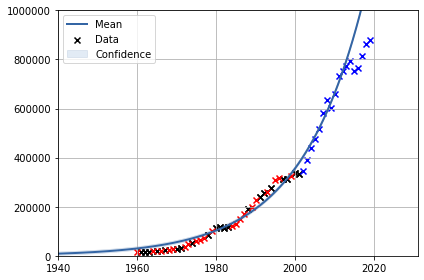

params:[2.63067226e-57 7.15945187e-02]
validate_rmse: 30881.233347523954 
 test_rmse: 328194.4976068957



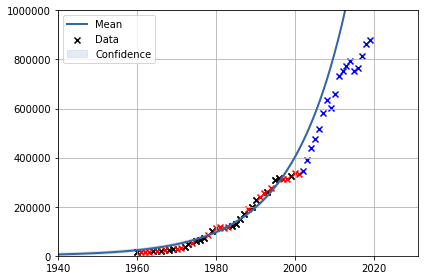

In [19]:
kf = KFold(n_splits=2, random_state=42, shuffle=True)

for train, val in kf.split(x_tv):
    x_train, y_train, x_val, y_val = x_tv[train], y_tv[train], x_tv[val], y_tv[val]
    result = gp_regression(
                         x_train=x_train,y_train=y_train,
                         x_val=x_val,y_val=y_val,
                         x_test=x_test,y_test=y_test,ylim=[0,1000000],
                         mean_func=exp, init_params=(1,-0.001),
                         kernel = GPy.kern.RBF(1),)

  0%|          | 0/256 [00:00<?, ?it/s]

[('box_cox', 1), ('sa', 1)]
params:[ 8.41645311e-02 -1.65772667e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5836.317726976942 
 test_rmse: 413330.5625030739



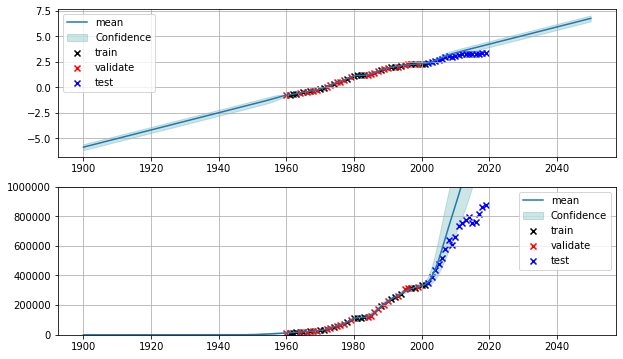

params:[ 9.27112975e-02 -1.82604827e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 14939.704829352497 
 test_rmse: 454979.0760180725



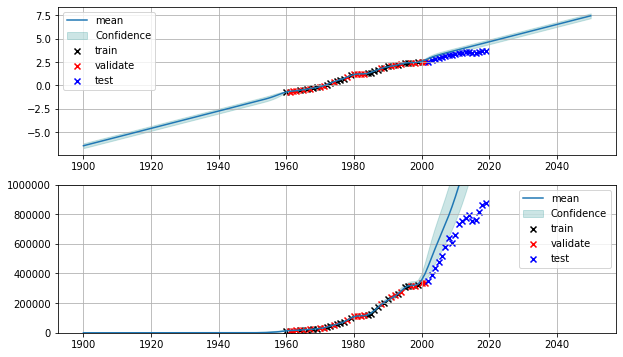

  0%|          | 1/256 [00:01<06:05,  1.43s/it]

params:[ 1.21739110e-01 -2.40412029e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 5863.8831580281485 
 test_rmse: 239308.06897994035



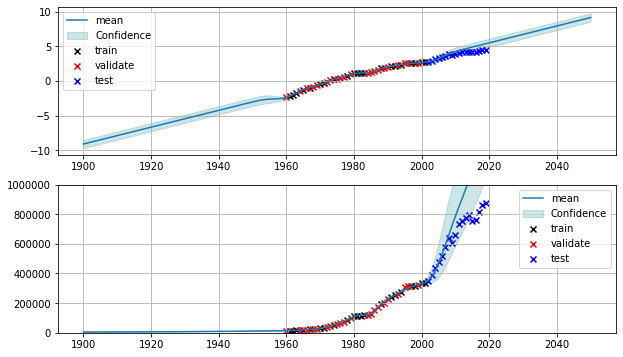

params:[ 1.2015282e-01 -2.3711597e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 10421.007471661957 
 test_rmse: 304427.5231168839



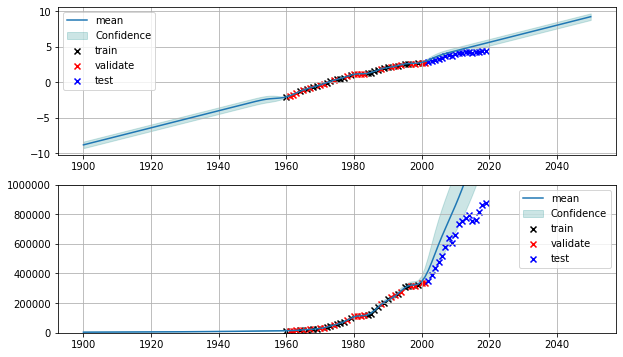

  1%|          | 2/256 [00:02<05:45,  1.36s/it]

params:[ 1.19800851e-01 -2.37196568e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5989.679025048762 
 test_rmse: 194934.09068674338



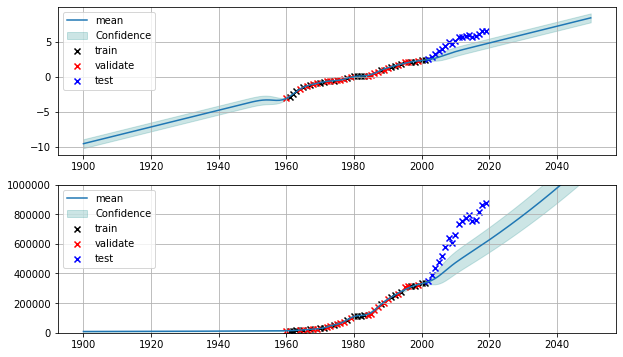

params:[ 1.13008711e-01 -2.23778523e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5748.0065949033105 
 test_rmse: 118701.44256780705



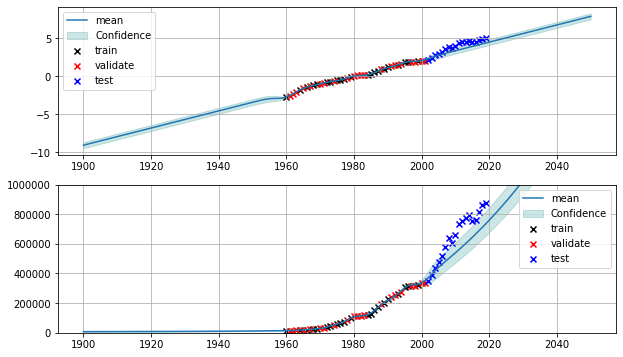

  1%|          | 3/256 [00:04<05:33,  1.32s/it]

params:[ 1.20574191e-01 -2.38123295e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 5864.005325141397 
 test_rmse: 134325.88243094433



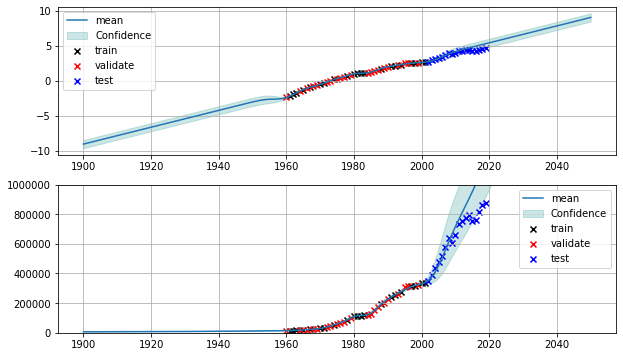

params:[ 1.18769991e-01 -2.34401028e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9612.434302682881 
 test_rmse: 175569.24313638636



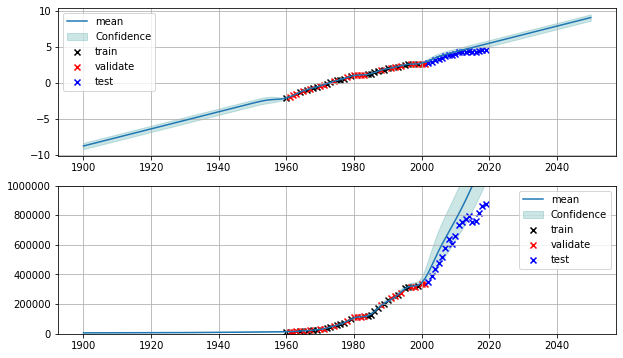

  2%|▏         | 4/256 [00:05<05:27,  1.30s/it]

params:[ 1.21057813e-01 -2.40793172e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5997.311445728715 
 test_rmse: 191341.3895848401



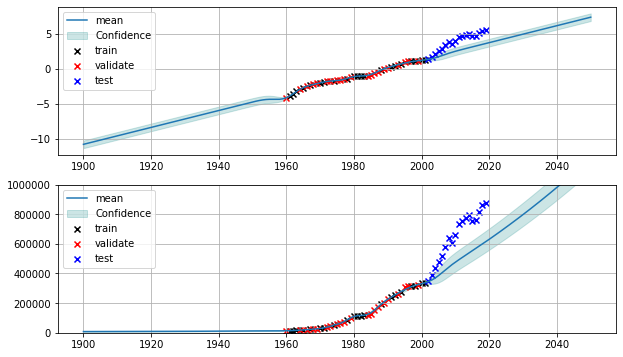

params:[ 1.06267236e-01 -2.11379281e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 4859.905818411771 
 test_rmse: 176684.506015895



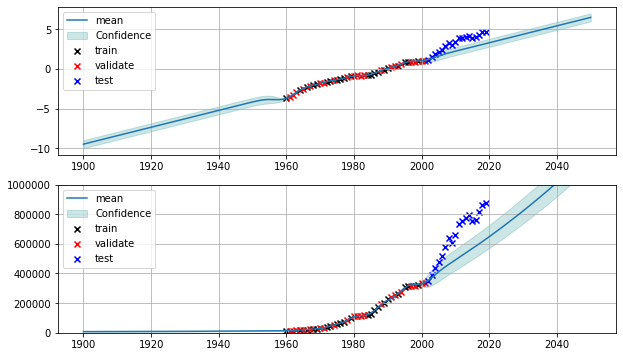

  2%|▏         | 5/256 [00:06<05:15,  1.26s/it]

params:[ 1.12118863e-01 -2.21836047e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6221.57015308848 
 test_rmse: 219549.7075557071



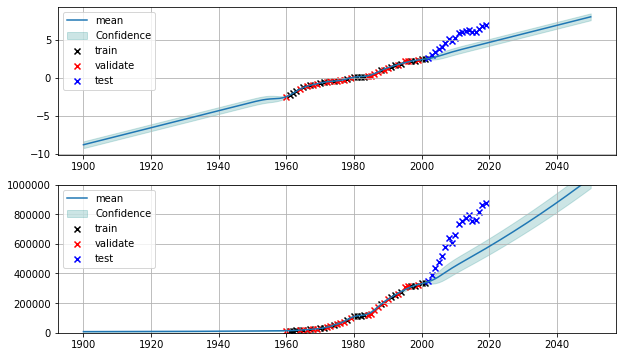

params:[ 1.14728553e-01 -2.26957256e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 4758.534112148073 
 test_rmse: 185394.60561381959



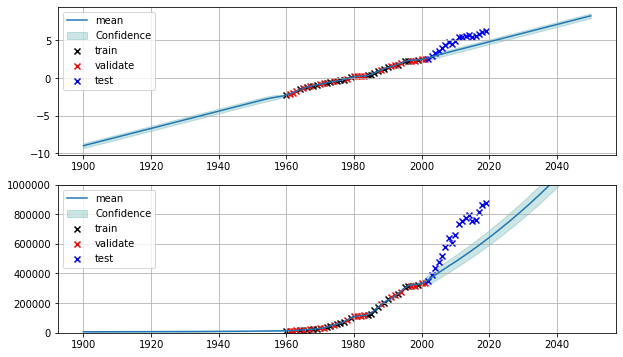

  2%|▏         | 6/256 [00:07<05:15,  1.26s/it]

params:[ 1.19180635e-01 -2.36027213e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6052.478257251617 
 test_rmse: 204561.44459975153



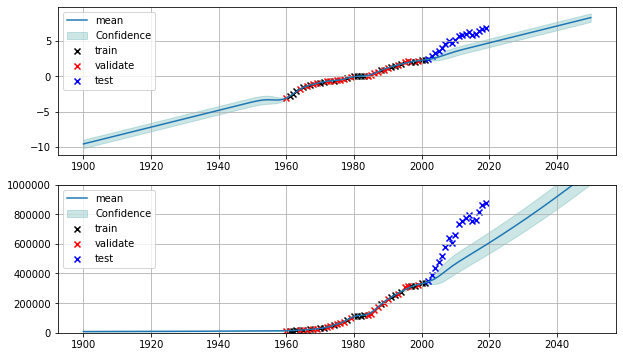

params:[ 1.13071165e-01 -2.23979367e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5909.377800090281 
 test_rmse: 122606.68984425113



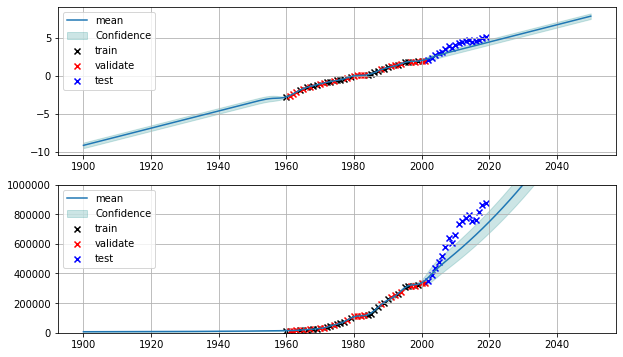

  3%|▎         | 7/256 [00:08<05:13,  1.26s/it]

params:[ 1.20939697e-01 -2.38887782e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 5858.339531877449 
 test_rmse: 79688.69817725336



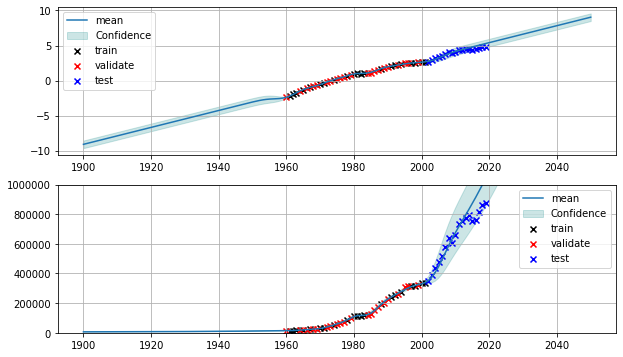

params:[ 1.19118640e-01 -2.35139846e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9432.008428527033 
 test_rmse: 107440.63947349325



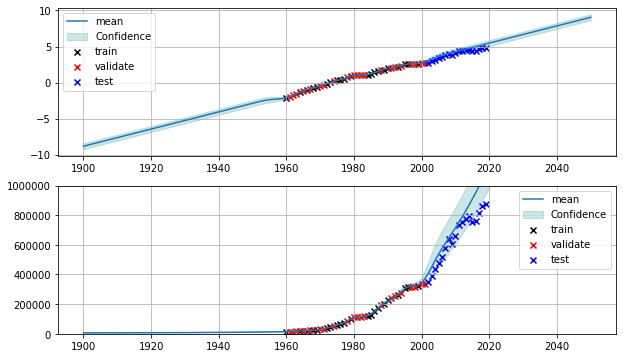

  3%|▎         | 8/256 [00:10<05:06,  1.23s/it]

params:[ 1.20213361e-01 -2.40152657e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6029.107422927146 
 test_rmse: 198401.39924695055



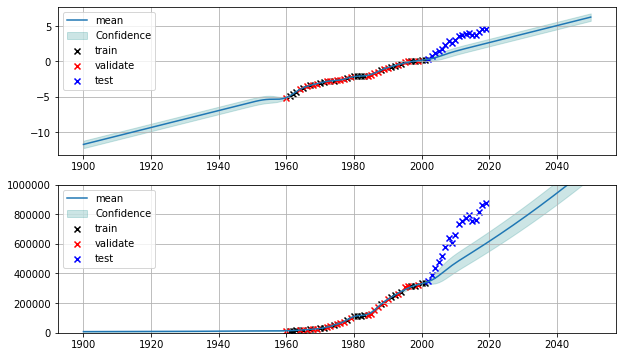

params:[ 1.09116162e-01 -2.18173046e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5123.351388642329 
 test_rmse: 144527.1323149448



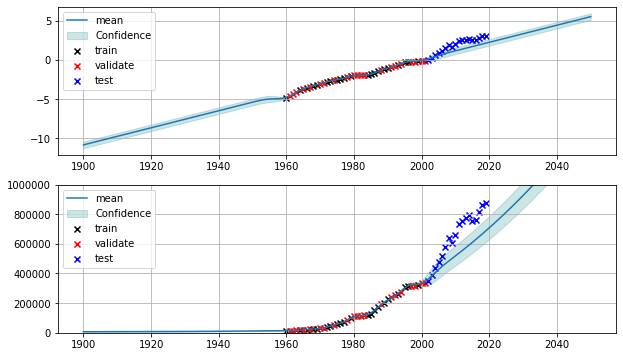

  4%|▎         | 9/256 [00:11<05:06,  1.24s/it]

params:[ 1.12576411e-01 -2.23179071e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8603.521525427705 
 test_rmse: 290222.8555568902



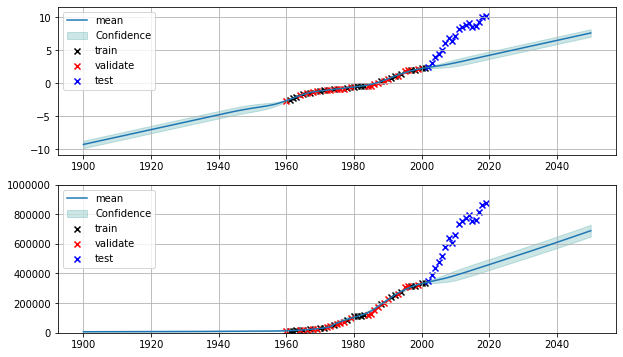

params:[ 1.07118809e-01 -2.12261407e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6492.78178403639 
 test_rmse: 301380.64657549455



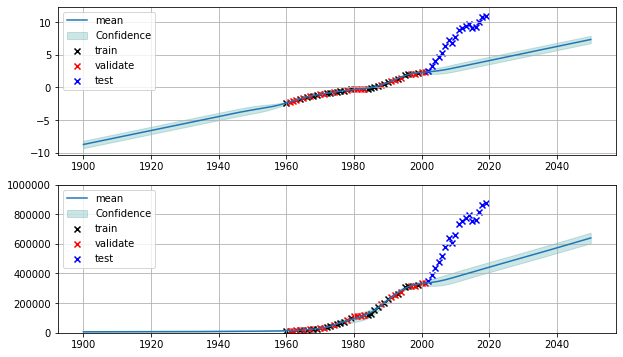

  4%|▍         | 10/256 [00:12<05:05,  1.24s/it]

params:[ 1.07402360e-01 -2.13375663e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 8374.583692149092 
 test_rmse: 261327.78746142893



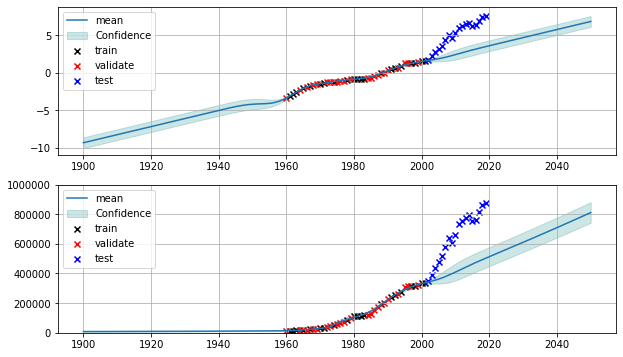

params:[ 1.08031930e-01 -2.14535086e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5146.148579490916 
 test_rmse: 246045.10201113464



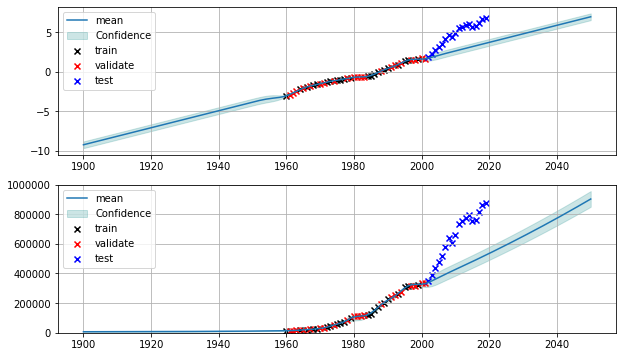

  4%|▍         | 11/256 [00:14<05:46,  1.42s/it]

params:[ 1.12462644e-01 -2.22540454e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6301.9220246495515 
 test_rmse: 225162.15949832767



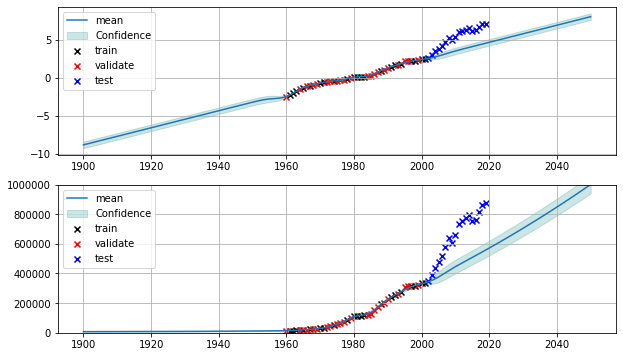

params:[ 1.16730895e-01 -2.30942551e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6532.509759199097 
 test_rmse: 180350.68752127362



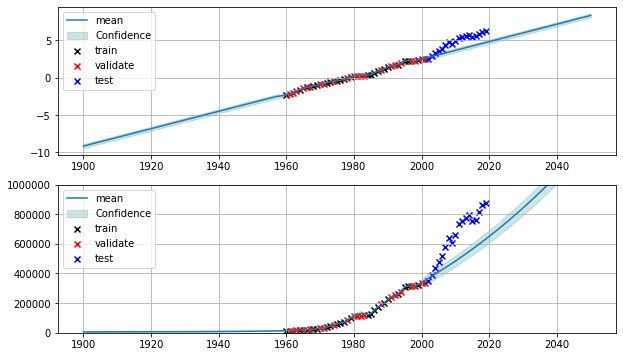

  5%|▍         | 12/256 [00:15<05:31,  1.36s/it]

params:[ 1.20118939e-01 -2.38960737e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6024.347807896396 
 test_rmse: 198867.01878699425



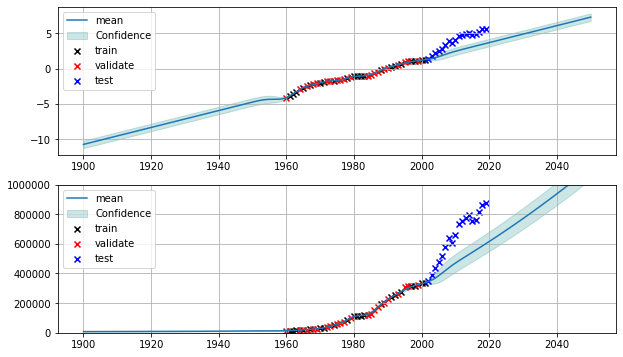

params:[ 1.08284064e-01 -2.15471491e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5096.042623798006 
 test_rmse: 145793.67300579793



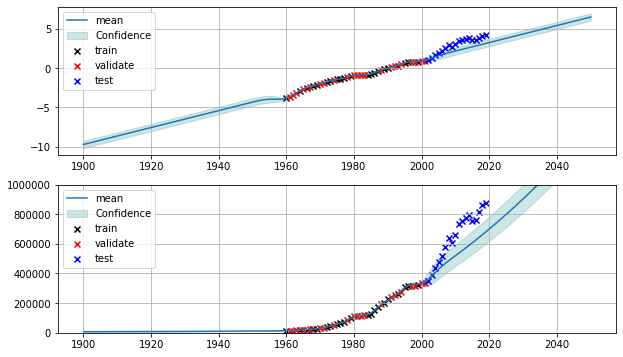

  5%|▌         | 13/256 [00:16<05:18,  1.31s/it]

params:[ 1.12462568e-01 -2.22540301e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6301.92844947769 
 test_rmse: 225162.53804075916



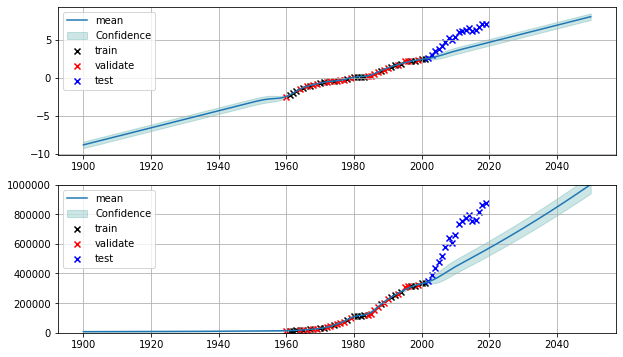

params:[ 1.16731219e-01 -2.30943193e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6532.454473135577 
 test_rmse: 180348.60306755896



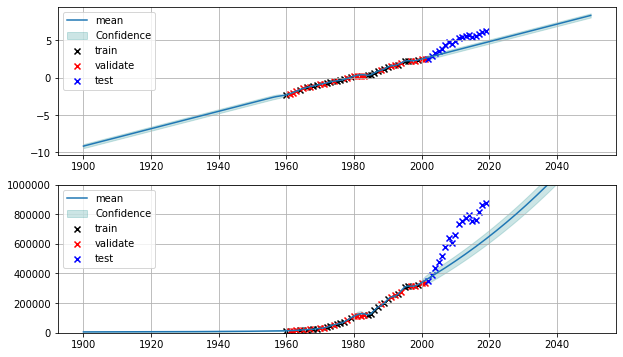

  5%|▌         | 14/256 [00:18<05:19,  1.32s/it]

params:[ 1.18770899e-01 -2.35255551e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6082.366569080994 
 test_rmse: 207792.56635955872



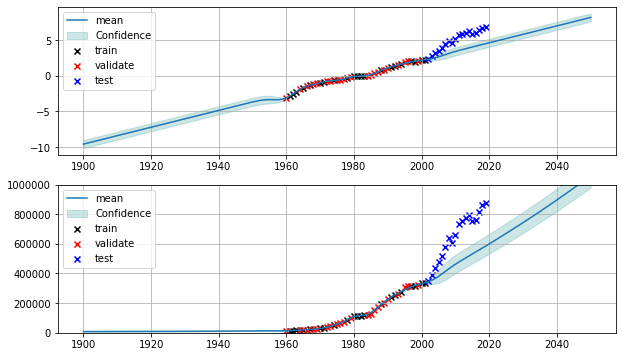

params:[ 1.14164170e-01 -2.26225053e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6812.188305654781 
 test_rmse: 96370.61712004816



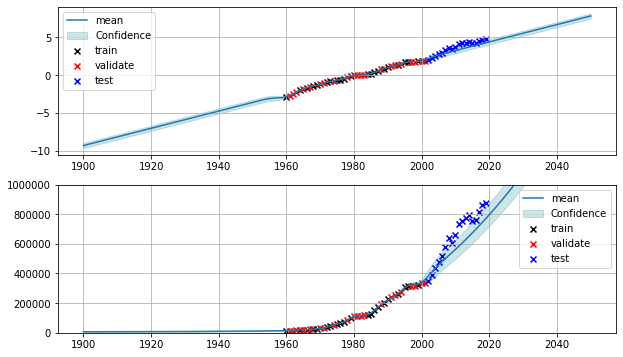

  6%|▌         | 15/256 [00:19<05:16,  1.32s/it]

params:[ 1.21192310e-01 -2.39412591e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 5856.298568491504 
 test_rmse: 57505.62475111644



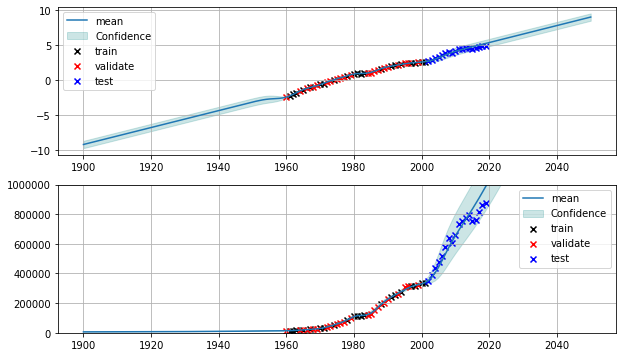

params:[ 1.19372426e-01 -2.35671575e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9354.87793482436 
 test_rmse: 76384.41171927819



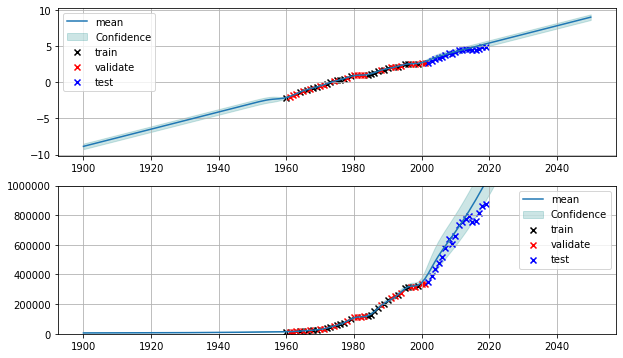

  6%|▋         | 16/256 [00:20<05:13,  1.31s/it]

params:[ 1.10828838e-01 -2.22772050e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 8426.73483330549 
 test_rmse: 254754.83400300264



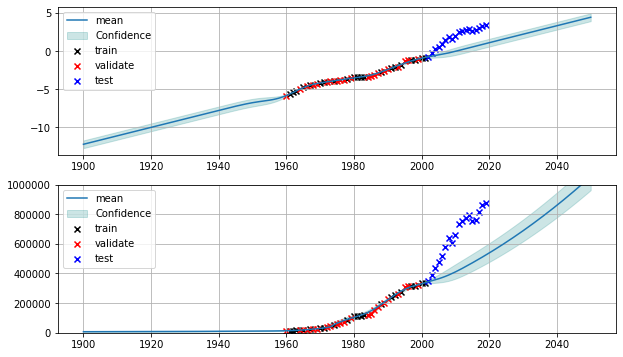

params:[ 1.03804761e-01 -2.09057526e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5472.218525579433 
 test_rmse: 161493.13517547428



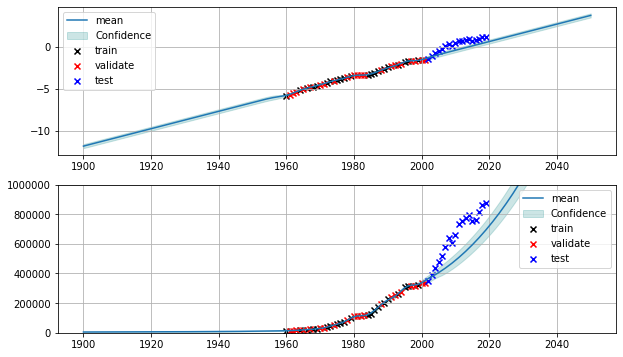

  7%|▋         | 17/256 [00:22<05:07,  1.29s/it]

params:[ 1.03549951e-01 -2.05483825e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 9041.956126934683 
 test_rmse: 330413.6711110186



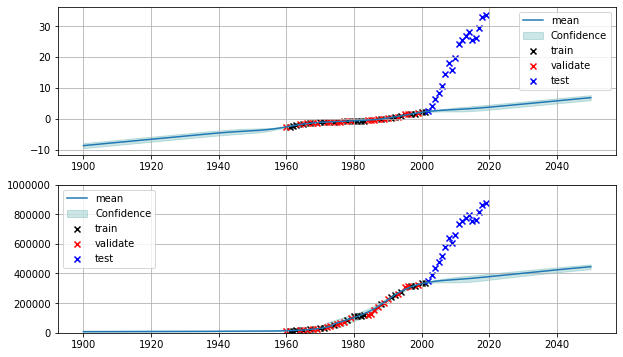

params:[ 1.05775641e-01 -2.09768134e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 5875.013445824725 
 test_rmse: 333124.4733525389



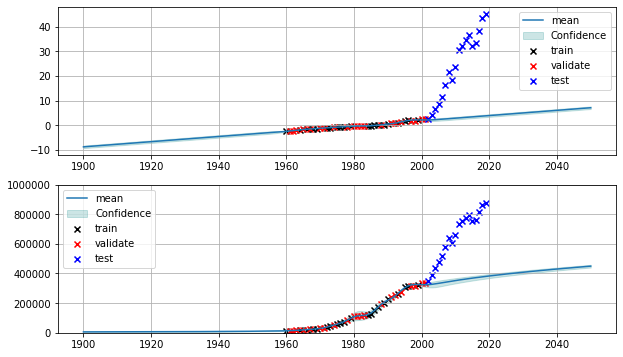

  7%|▋         | 18/256 [00:23<05:12,  1.31s/it]

params:[ 1.01270305e-01 -2.01398783e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6904.1722215190475 
 test_rmse: 323755.0795440107



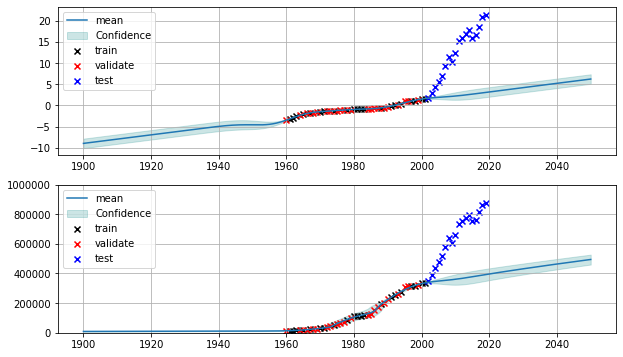

params:[ 1.06477842e-01 -2.11866486e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5431.485838458276 
 test_rmse: 305272.5270886365



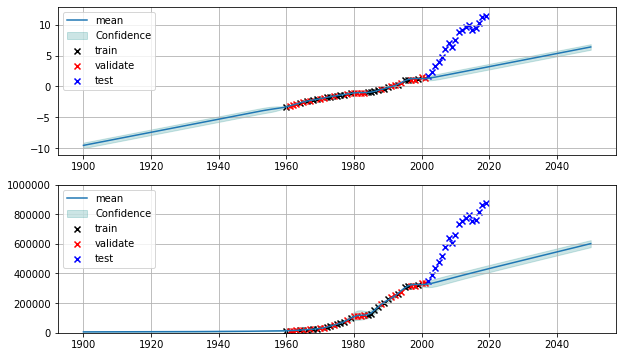

  7%|▋         | 19/256 [00:24<05:15,  1.33s/it]

params:[ 1.10471416e-01 -2.18990798e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 8820.371431891497 
 test_rmse: 296419.7640837832



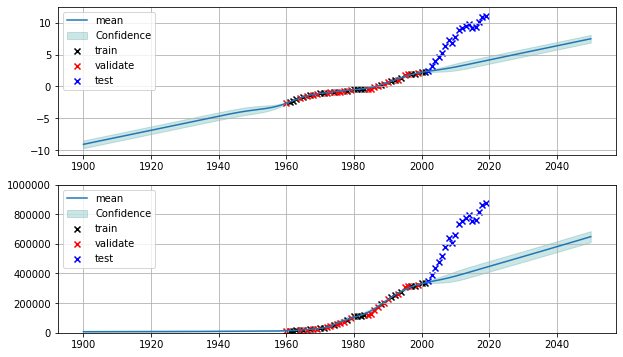

params:[ 1.11359971e-01 -2.20646467e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6066.746613039596 
 test_rmse: 292831.28500801657



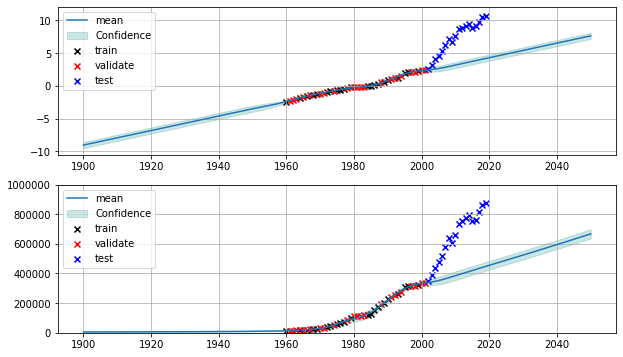

  8%|▊         | 20/256 [00:26<05:16,  1.34s/it]

params:[ 1.03909927e-01 -2.07337794e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6939.5171517482295 
 test_rmse: 269179.83031565946



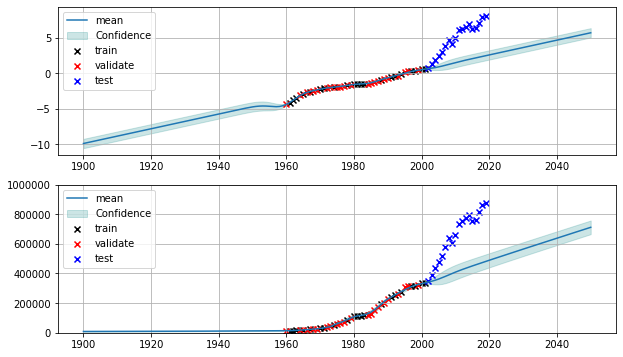

params:[ 1.06586480e-01 -2.12503606e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5346.656845437367 
 test_rmse: 256834.35831339142



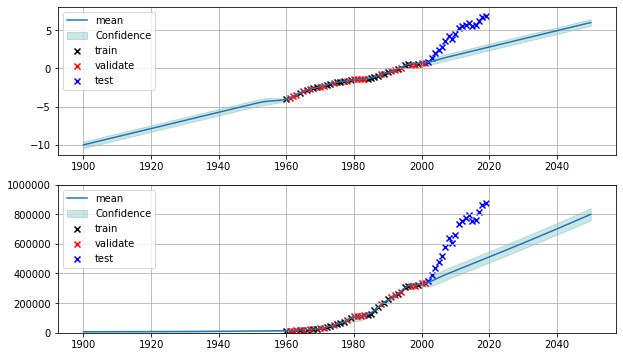

  8%|▊         | 21/256 [00:27<05:23,  1.38s/it]

params:[ 1.09783201e-01 -2.17637765e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8694.716630741445 
 test_rmse: 297759.943960527



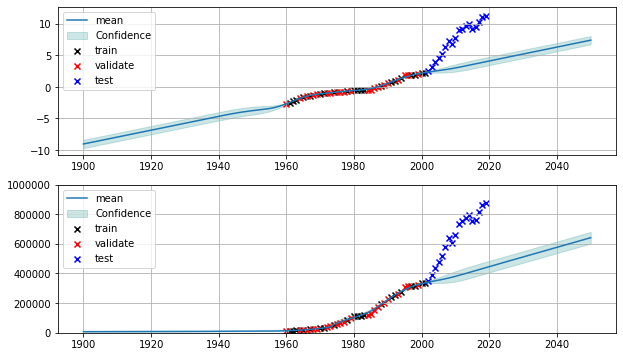

params:[ 1.10300102e-01 -2.18630301e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6291.323905568572 
 test_rmse: 288363.07932547043



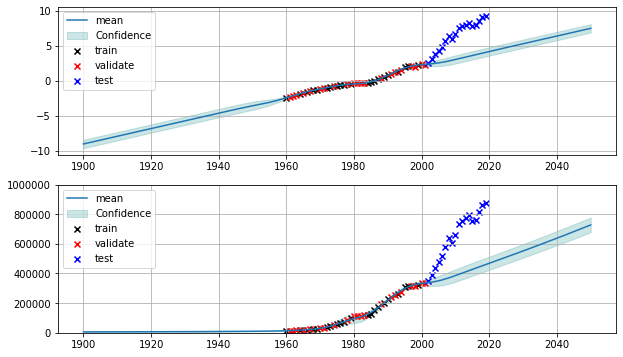

  9%|▊         | 22/256 [00:28<05:19,  1.37s/it]

params:[ 1.08181961e-01 -2.14949472e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 8408.96238325342 
 test_rmse: 259366.89193092985



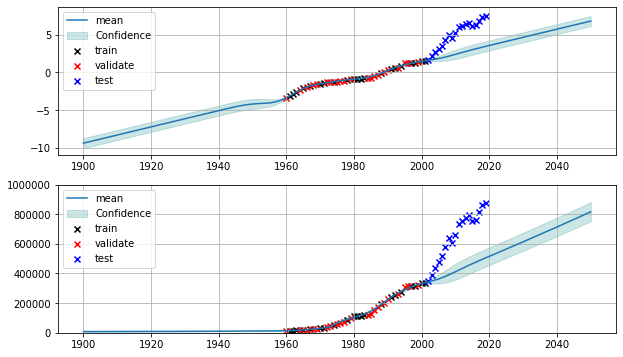

params:[ 1.10776430e-01 -2.19933186e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5081.318686968743 
 test_rmse: 242927.8311844959



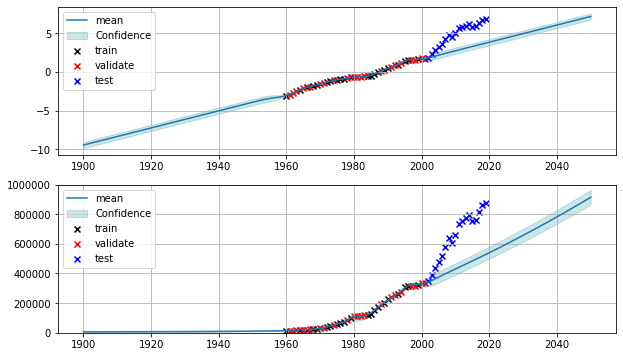

  9%|▉         | 23/256 [00:30<05:17,  1.36s/it]

params:[ 1.12737733e-01 -2.23098788e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6355.3975810354605 
 test_rmse: 227866.46331576767



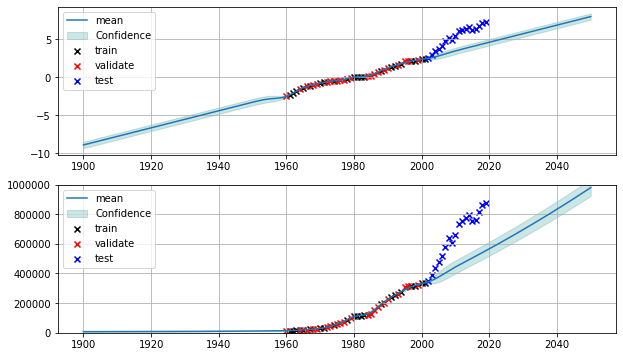

params:[ 1.20821349e-01 -2.39046944e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 7103.299081078291 
 test_rmse: 152834.39039381364



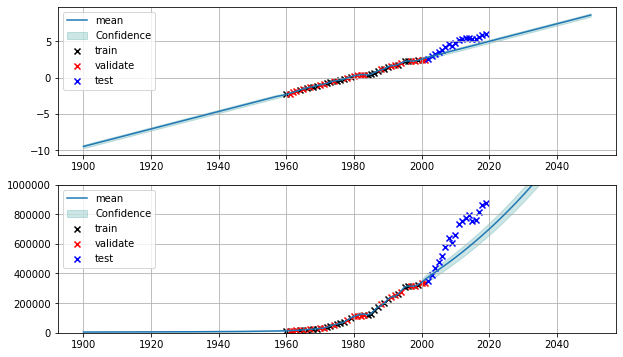

  9%|▉         | 24/256 [00:32<05:39,  1.46s/it]

params:[ 1.17276565e-01 -2.34287769e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6179.484542185531 
 test_rmse: 216761.92936223903



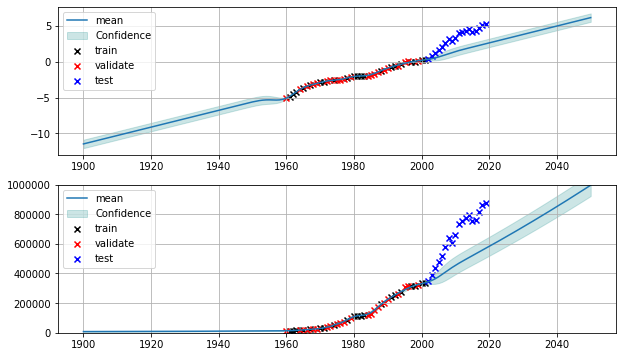

params:[ 1.14906066e-01 -2.29851719e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 7196.796425429716 
 test_rmse: 61668.099409748604



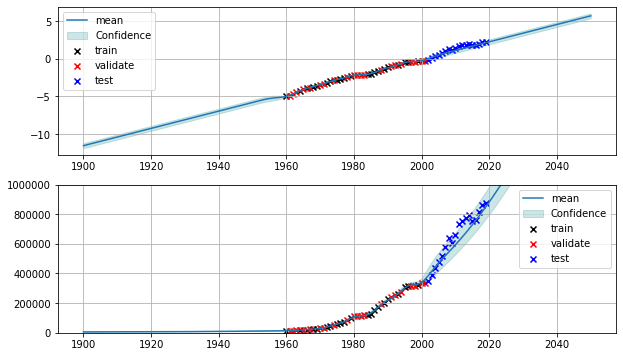

 10%|▉         | 25/256 [00:33<05:52,  1.53s/it]

params:[ 1.10471533e-01 -2.18991029e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8820.36029587441 
 test_rmse: 296419.28369847446



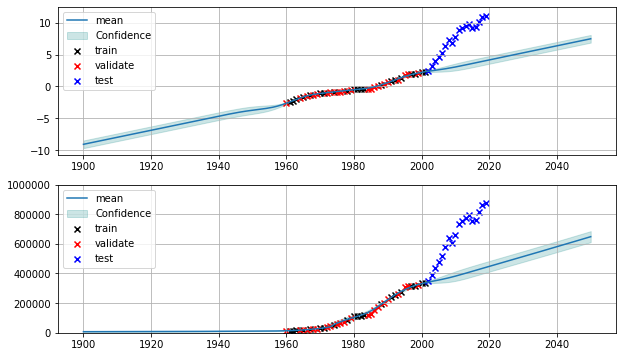

params:[ 1.11361004e-01 -2.20648504e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6066.626433079276 
 test_rmse: 292828.62582012545



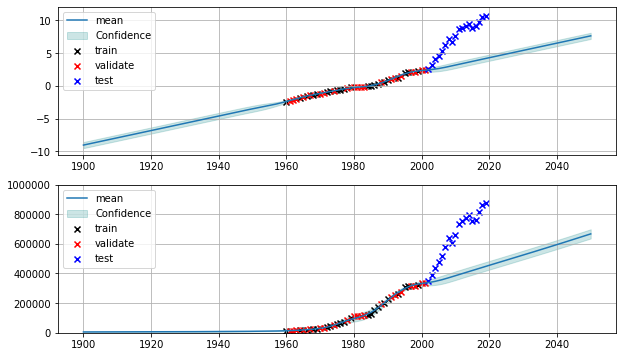

 10%|█         | 26/256 [00:35<05:35,  1.46s/it]

params:[ 1.08181827e-01 -2.14949207e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 7034.316927859072 
 test_rmse: 256814.48975609985



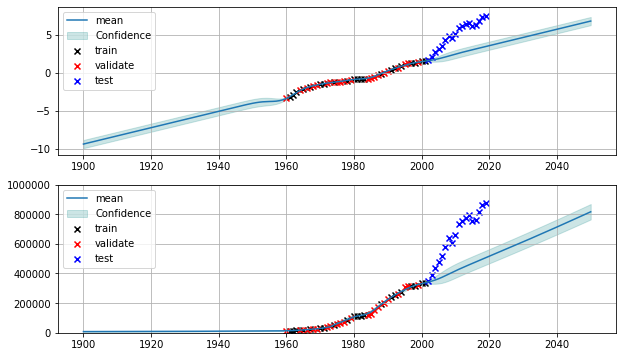

params:[ 1.10778075e-01 -2.19936416e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5081.288045809438 
 test_rmse: 242923.69122880857



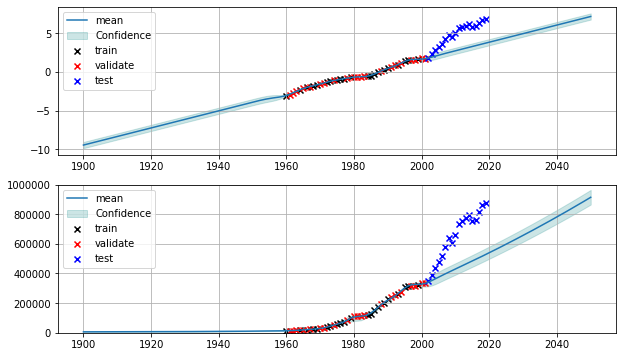

 11%|█         | 27/256 [00:36<05:33,  1.46s/it]

params:[ 1.12736264e-01 -2.23095907e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6355.414620975338 
 test_rmse: 227881.16121292274



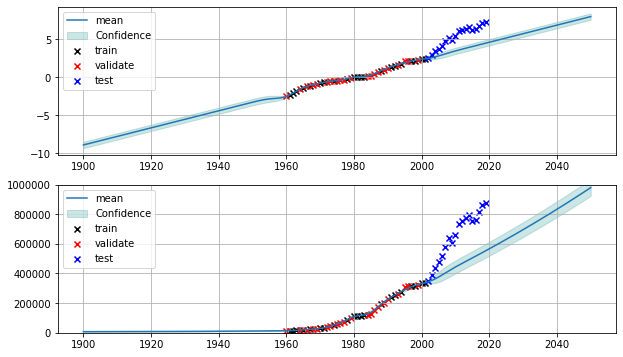

params:[ 1.20817928e-01 -2.39040177e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 7102.297747850859 
 test_rmse: 152864.5609826525



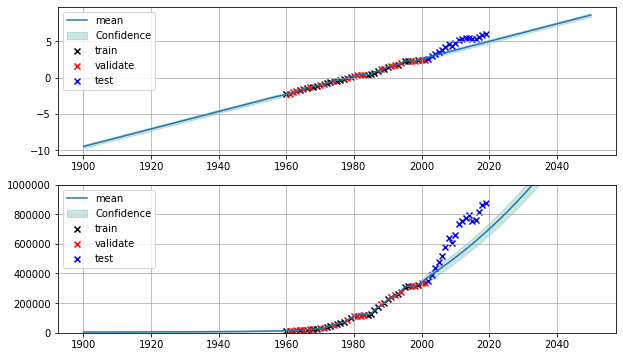

 11%|█         | 28/256 [00:37<05:25,  1.43s/it]

params:[ 1.17277651e-01 -2.33289972e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6179.539047478539 
 test_rmse: 216757.418893625



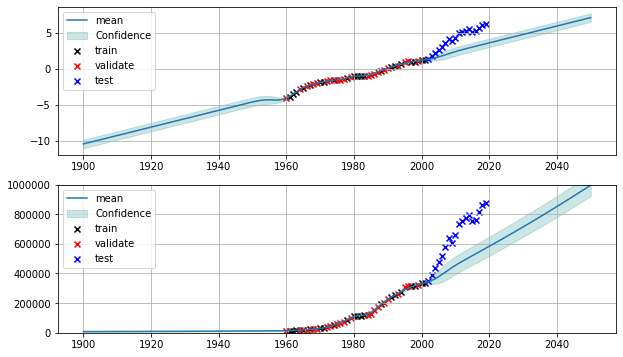

params:[ 1.13996489e-01 -2.26936044e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6586.446292712109 
 test_rmse: 58183.490678378665



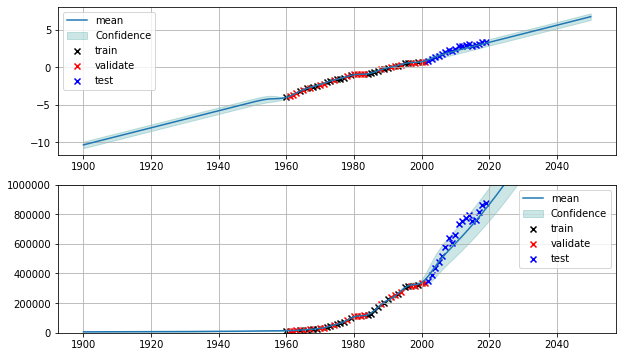

 11%|█▏        | 29/256 [00:39<05:29,  1.45s/it]

params:[ 1.12736209e-01 -2.23095798e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6355.417164086606 
 test_rmse: 227881.73254059232



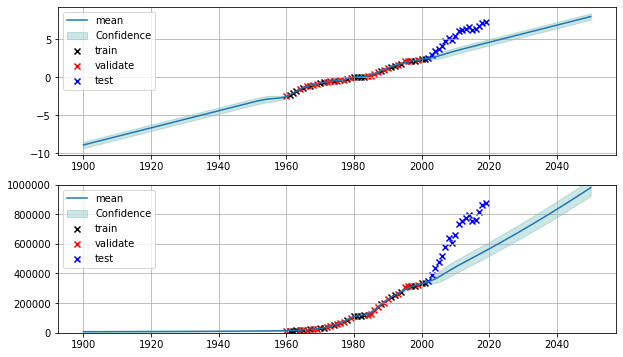

params:[ 1.20818361e-01 -2.39041035e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 7102.384417532101 
 test_rmse: 152861.89298800085



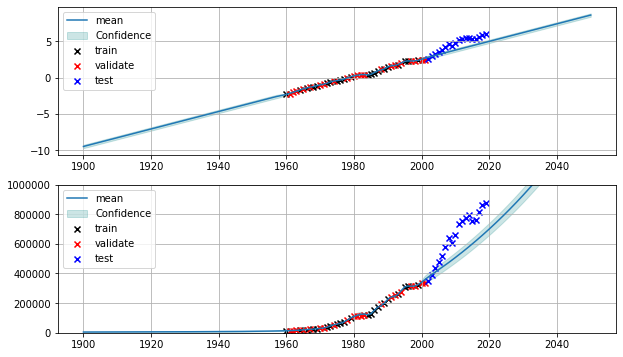

 12%|█▏        | 30/256 [00:40<05:15,  1.40s/it]

params:[ 1.18496273e-01 -2.34737058e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6096.090683026609 
 test_rmse: 208701.98367657757



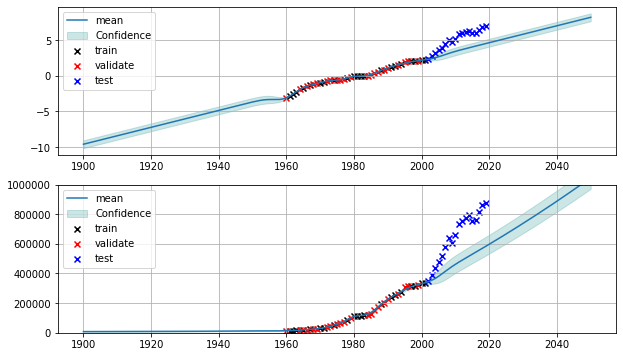

params:[ 1.17959376e-01 -2.33858121e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 8788.76628579135 
 test_rmse: 41276.49523395467



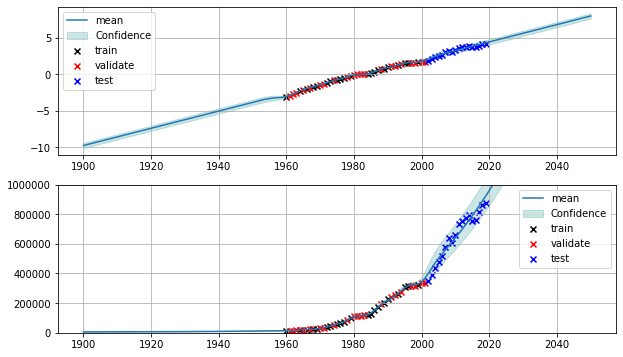

 12%|█▏        | 31/256 [00:42<05:17,  1.41s/it]

params:[ 1.21334673e-01 -2.39708768e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 5855.7281282797485 
 test_rmse: 49154.184742594705



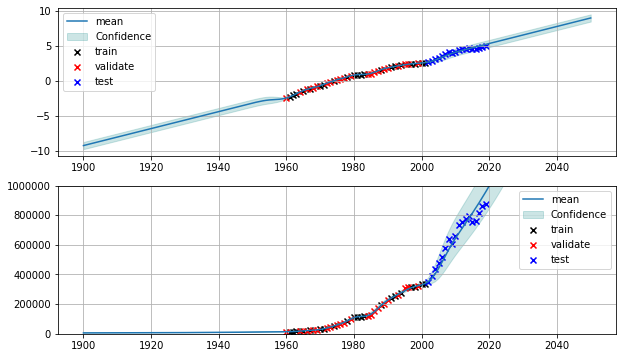

params:[ 1.19516843e-01 -2.35974490e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9311.990162017786 
 test_rmse: 61493.205765525374



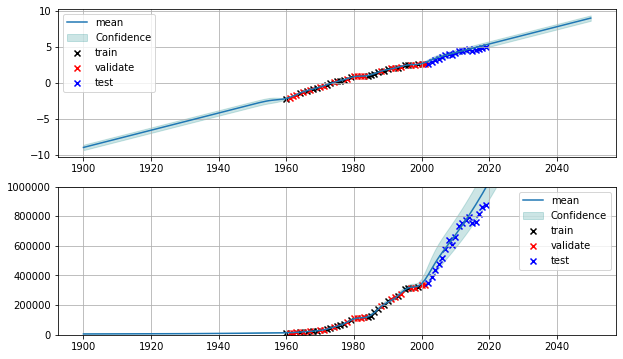

 12%|█▎        | 32/256 [00:43<05:09,  1.38s/it]

params:[ 8.84727802e-02 -1.79682283e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 9461.249533977401 
 test_rmse: 300852.19103907887



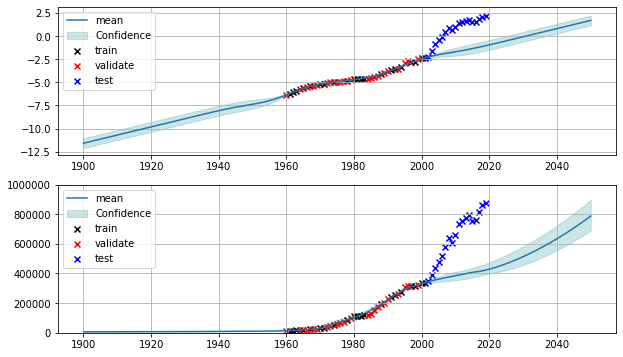

params:[ 8.13778616e-02 -1.65682725e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 4638.10308470607 
 test_rmse: 261502.78200179417



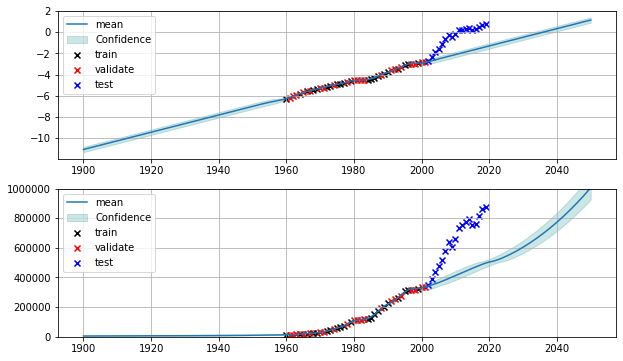

 13%|█▎        | 33/256 [00:44<05:03,  1.36s/it]

params:[ 9.60454622e-02 -1.90843366e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8946.319060220161 
 test_rmse: 337785.23573844193



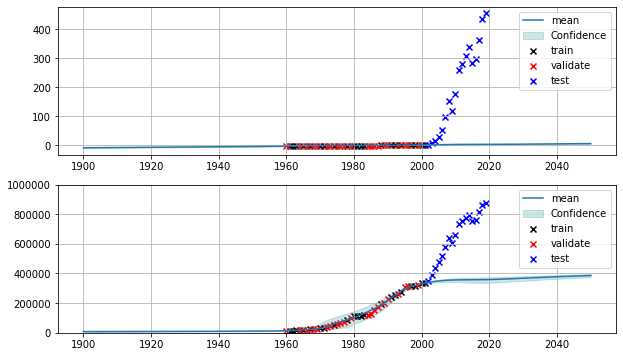

params:[ 1.00309242e-01 -1.98933679e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6394.6965418849695 
 test_rmse: 345434.7919008096



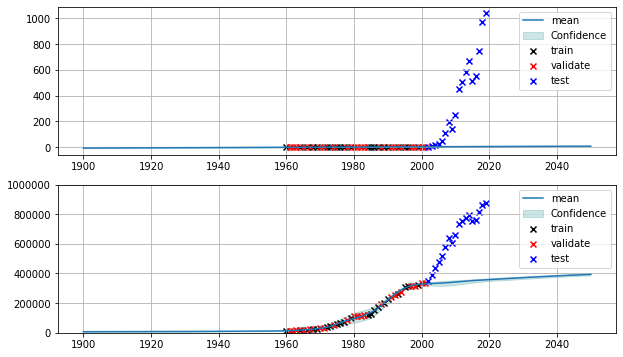

 13%|█▎        | 34/256 [00:46<05:08,  1.39s/it]

params:[ 9.44847737e-02 -1.88210118e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 8198.943207330205 
 test_rmse: 341017.3291777497



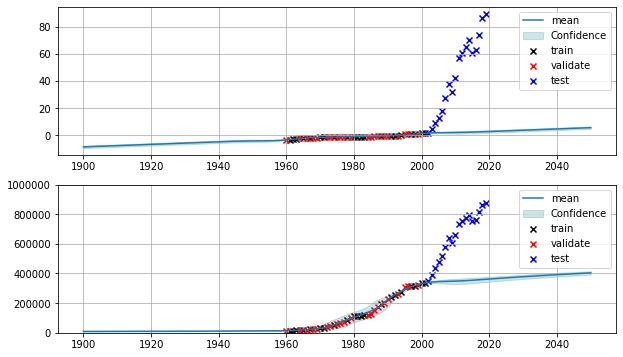

params:[ 9.66951117e-02 -1.92655848e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6226.188965737803 
 test_rmse: 344352.07384279754



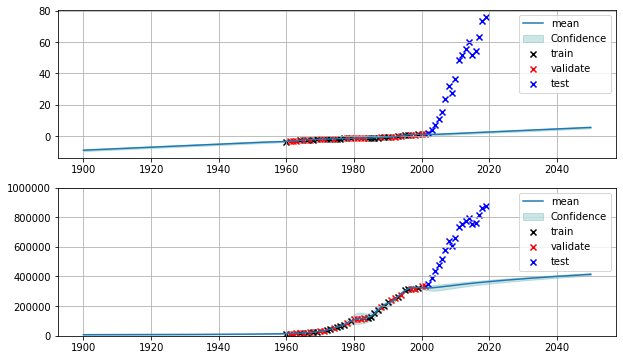

 14%|█▎        | 35/256 [00:47<04:58,  1.35s/it]

params:[ 1.02860041e-01 -2.04113029e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9191.891002195227 
 test_rmse: 331132.5933781796



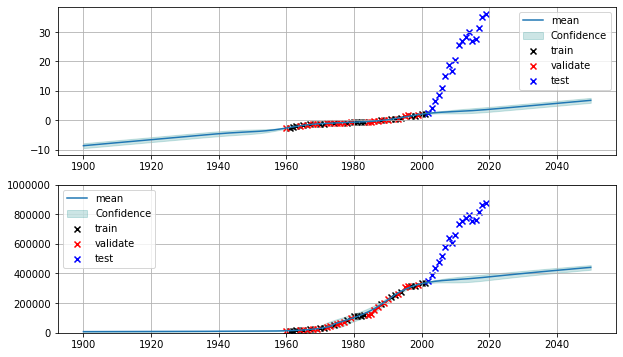

params:[ 1.03048552e-01 -2.04433223e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6270.30895316374 
 test_rmse: 338289.4837513885



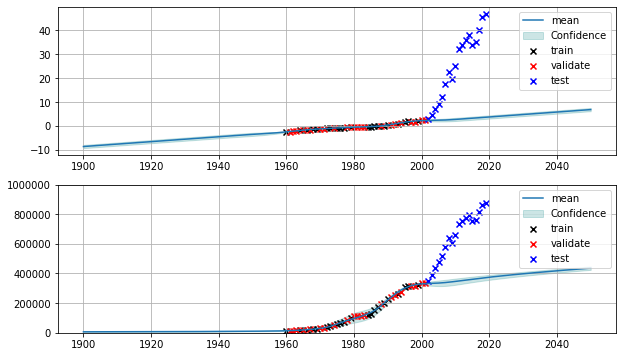

 14%|█▍        | 36/256 [00:48<04:59,  1.36s/it]

params:[ 1.00206842e-01 -2.00281938e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6938.082388731143 
 test_rmse: 324586.6051776332



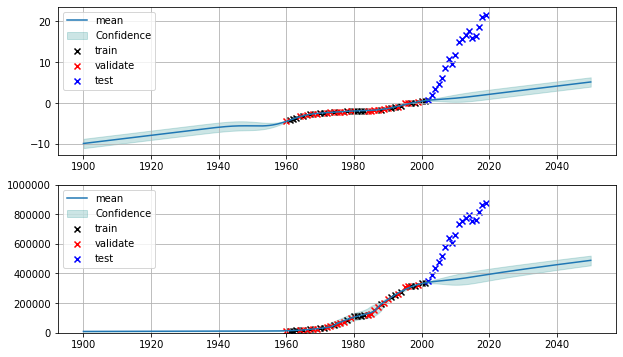

params:[ 1.01726616e-01 -2.03324884e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6415.118142219472 
 test_rmse: 312403.9738241451



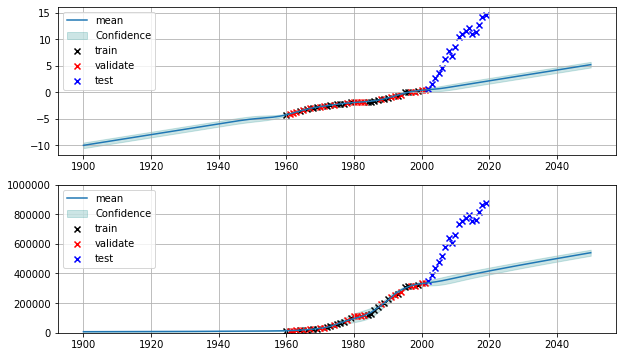

 14%|█▍        | 37/256 [00:50<04:50,  1.33s/it]

params:[ 9.64888889e-02 -1.91515748e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6996.861220172066 
 test_rmse: 335472.8291006159



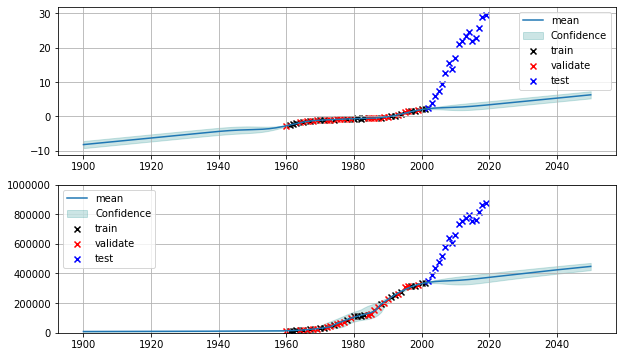

params:[ 1.02170778e-01 -2.02894105e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6442.5581492525935 
 test_rmse: 340658.63864392345



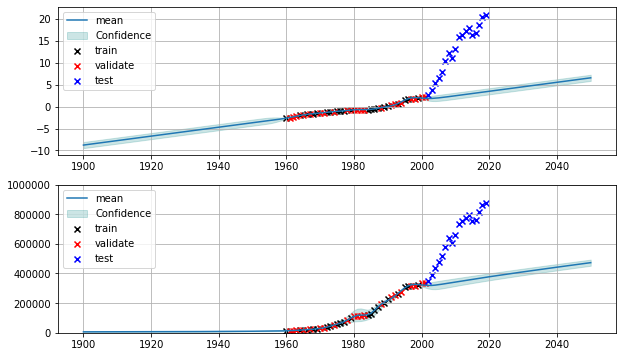

 15%|█▍        | 38/256 [00:51<05:00,  1.38s/it]

params:[ 1.00542657e-01 -1.99962854e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6963.917388367102 
 test_rmse: 324432.671478679



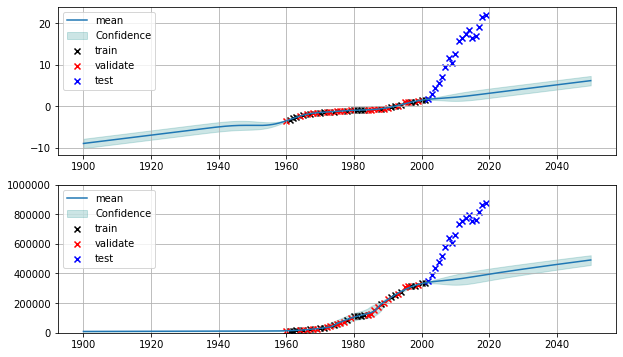

params:[ 1.03530079e-01 -2.06064561e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5701.438225661951 
 test_rmse: 312621.87852353434



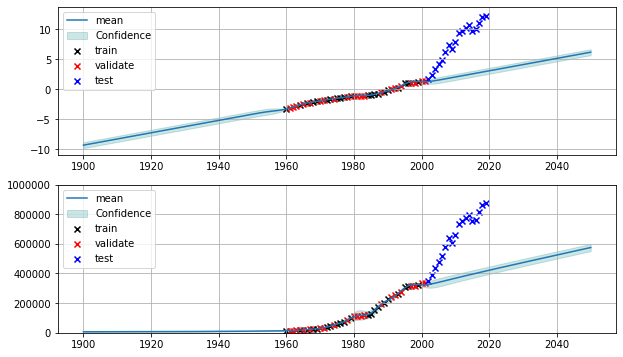

 15%|█▌        | 39/256 [00:53<05:10,  1.43s/it]

params:[ 1.09747442e-01 -2.17551678e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 8926.587661519727 
 test_rmse: 298836.7522724377



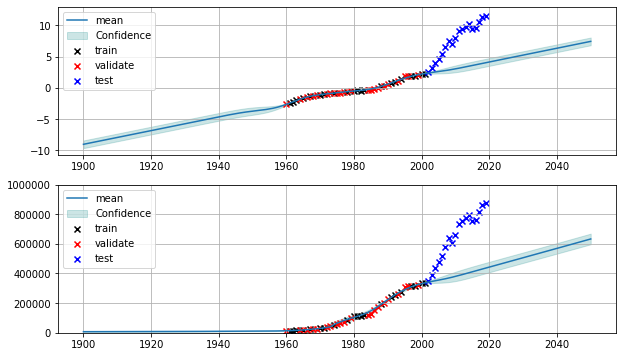

params:[ 1.08372569e-01 -2.14770819e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6375.535795262982 
 test_rmse: 301852.2265446252



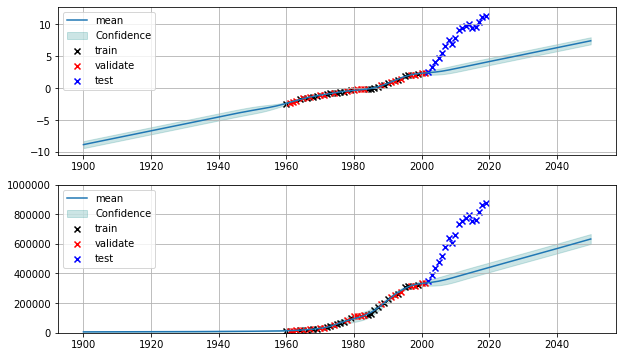

 16%|█▌        | 40/256 [00:54<05:07,  1.42s/it]

params:[ 1.04042183e-01 -2.08705293e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 8544.38093035486 
 test_rmse: 275147.17073878105



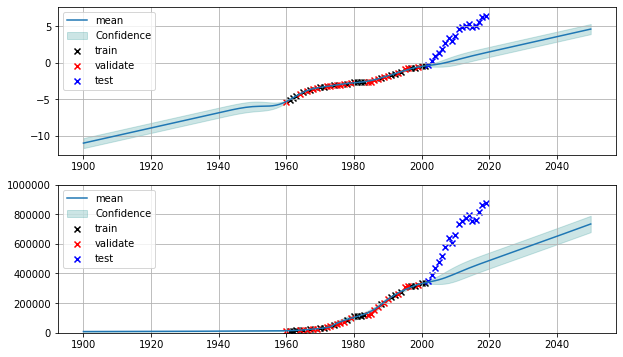

params:[ 1.04318174e-01 -2.09097265e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5270.939197799909 
 test_rmse: 261658.59413348525



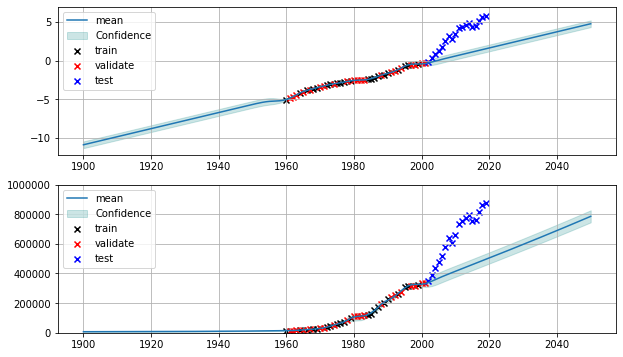

 16%|█▌        | 41/256 [00:55<05:02,  1.41s/it]

params:[ 1.00002684e-01 -1.98432136e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8330.517797969493 
 test_rmse: 332438.50451190467



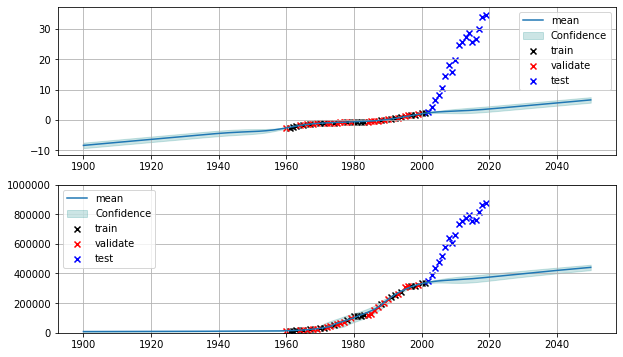

params:[ 9.96059648e-02 -1.97679874e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6425.0119658895455 
 test_rmse: 342113.06728566793



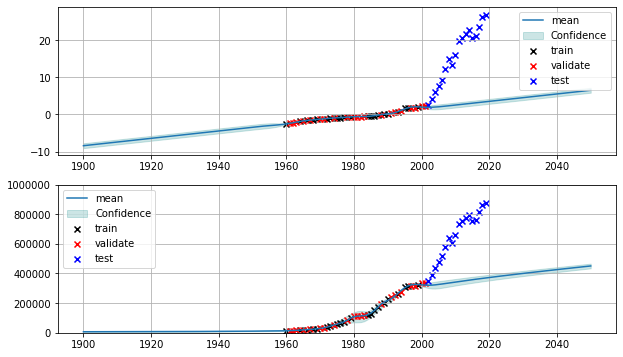

 16%|█▋        | 42/256 [00:57<04:54,  1.37s/it]

params:[ 1.01085075e-01 -2.01048038e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 7143.982152091829 
 test_rmse: 324245.0971759563



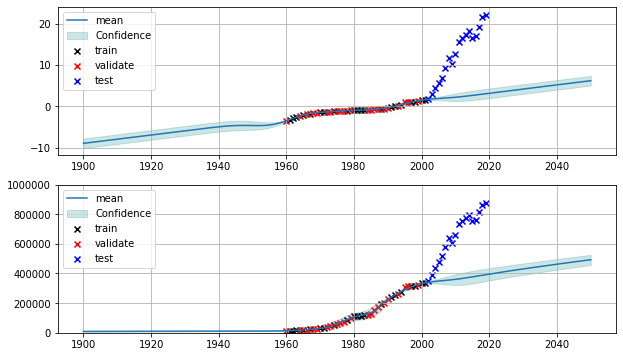

params:[ 1.01773442e-01 -2.02566504e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5900.593821786006 
 test_rmse: 313831.7626779767



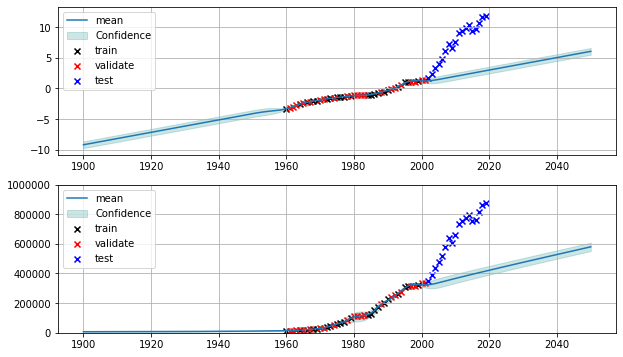

 17%|█▋        | 43/256 [00:58<04:49,  1.36s/it]

params:[ 1.10232436e-01 -2.18536930e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 8733.085535551205 
 test_rmse: 297644.546897156



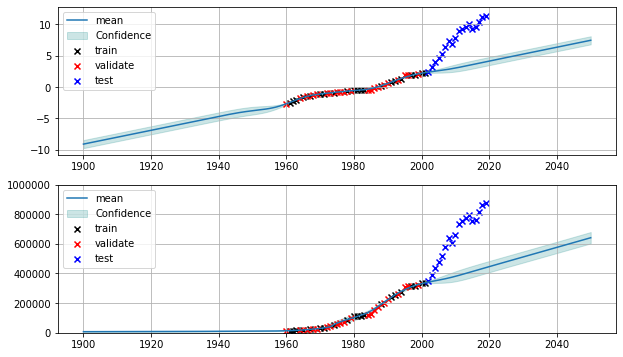

params:[ 1.09405842e-01 -2.16894627e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6785.04929389622 
 test_rmse: 294772.017457069



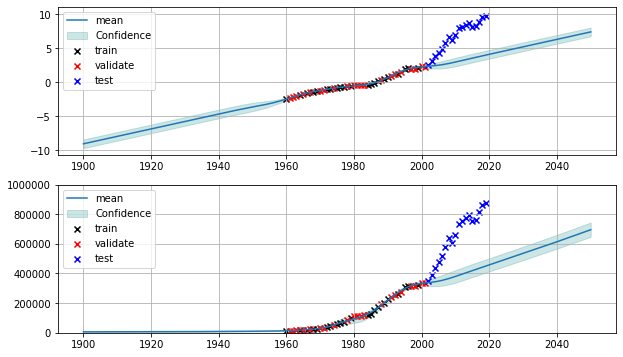

 17%|█▋        | 44/256 [00:59<04:41,  1.33s/it]

params:[ 1.04552923e-01 -2.08630538e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 8391.957259163019 
 test_rmse: 273136.9235318944



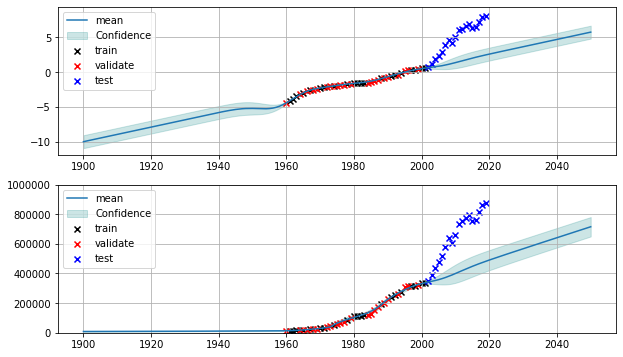

params:[ 1.04540031e-01 -2.08501169e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5249.108802860238 
 test_rmse: 259213.79614223394



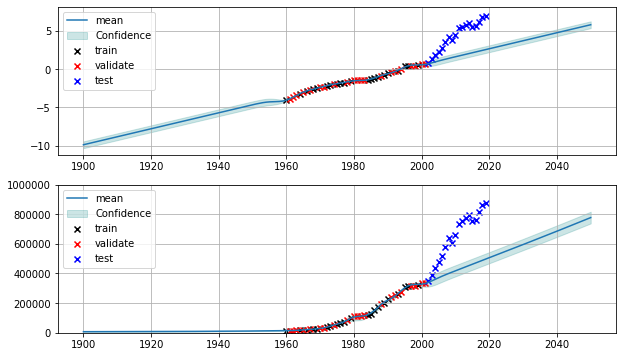

 18%|█▊        | 45/256 [01:01<04:48,  1.37s/it]

params:[ 1.10231999e-01 -2.18536076e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8733.214539404811 
 test_rmse: 297647.4128238851



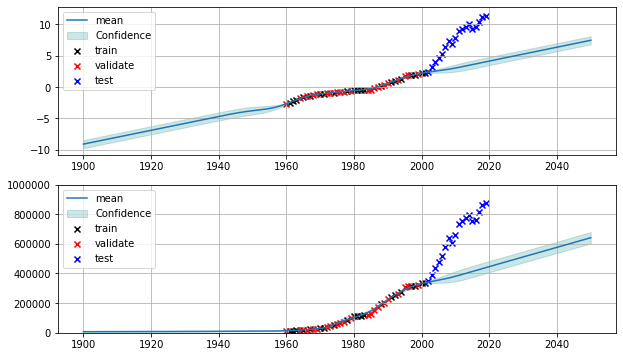

params:[ 1.09405910e-01 -2.16894756e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6784.948459441123 
 test_rmse: 294771.6185276386



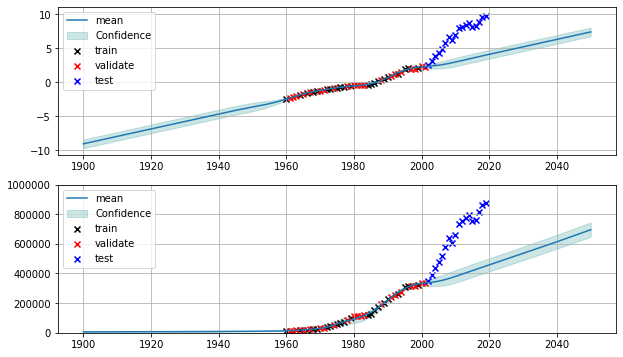

 18%|█▊        | 46/256 [01:02<04:47,  1.37s/it]

params:[ 1.08712038e-01 -2.16017628e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 8426.380503854221 
 test_rmse: 257991.68674062184



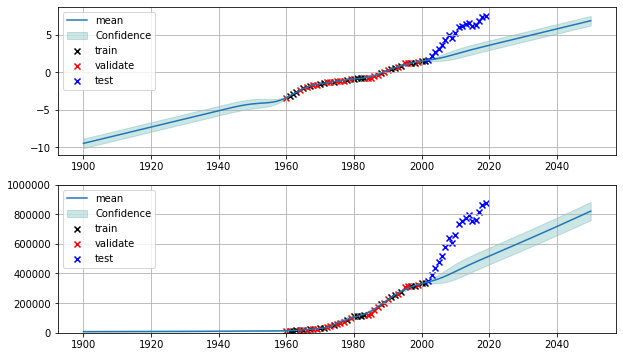

params:[ 1.09060547e-01 -2.16606195e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 4982.714559876296 
 test_rmse: 245578.03475153496



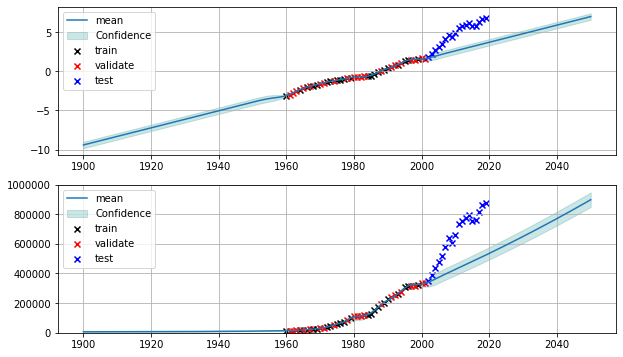

 18%|█▊        | 47/256 [01:04<05:10,  1.48s/it]

params:[ 1.12935278e-01 -2.23498153e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6391.471293677097 
 test_rmse: 229289.33439382055



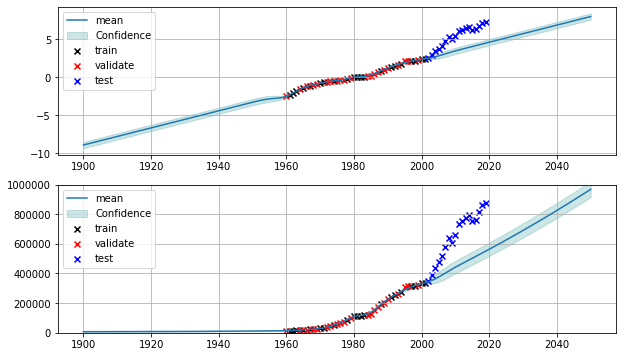

params:[ 1.17306553e-01 -2.32106140e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 4797.7217877148505 
 test_rmse: 185993.46420675988



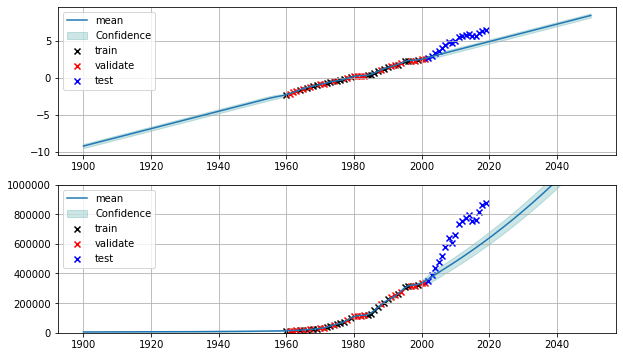

 19%|█▉        | 48/256 [01:05<05:04,  1.46s/it]

params:[ 1.09266698e-01 -2.19722876e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 8757.03536810297 
 test_rmse: 263046.2464385369



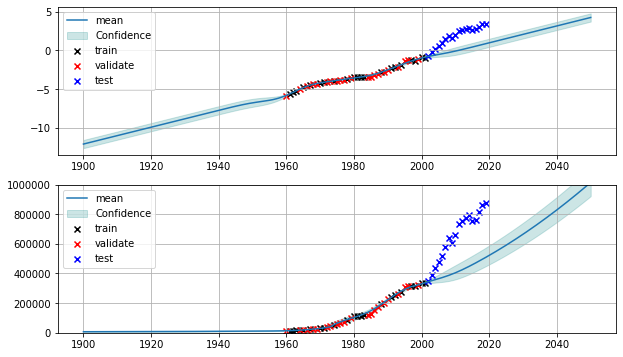

params:[ 1.02616362e-01 -2.06595374e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 4587.654956395182 
 test_rmse: 204029.57873709188



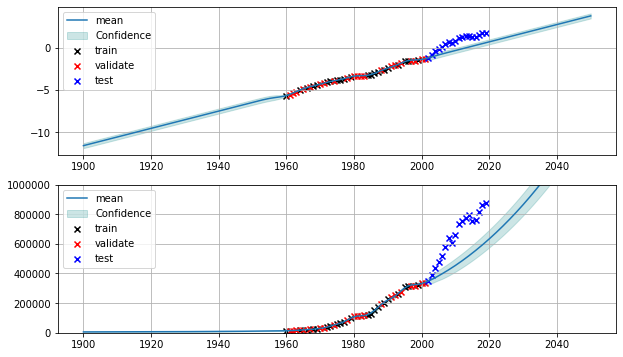

 19%|█▉        | 49/256 [01:07<05:15,  1.52s/it]

params:[ 1.02859458e-01 -2.04111869e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 9191.909308388813 
 test_rmse: 331133.1519696144



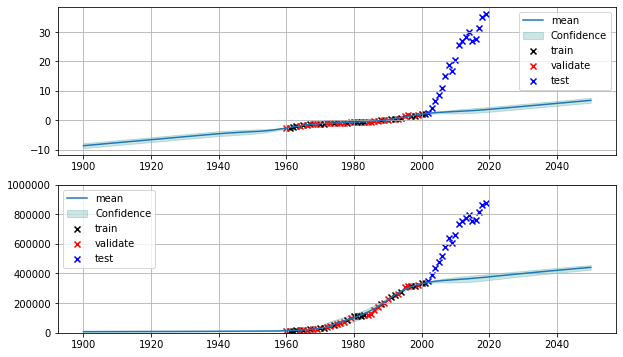

params:[ 1.03048974e-01 -2.04434073e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6270.265318536808 
 test_rmse: 338289.45634057967



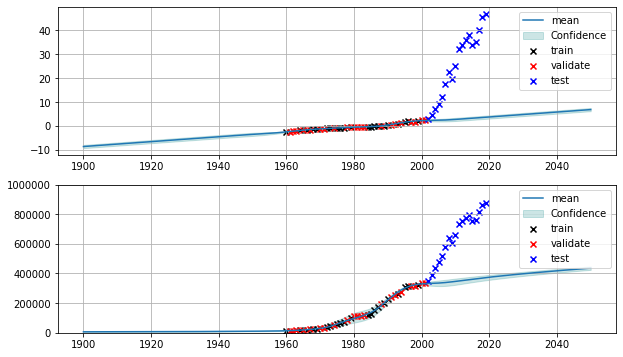

 20%|█▉        | 50/256 [01:09<05:18,  1.55s/it]

params:[ 1.00542913e-01 -1.99963358e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6963.93479713312 
 test_rmse: 324432.6175257055



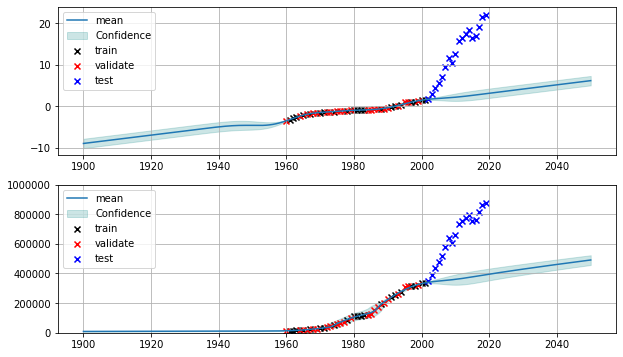

params:[ 1.03530020e-01 -2.06064441e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5701.438332814086 
 test_rmse: 312622.94688938



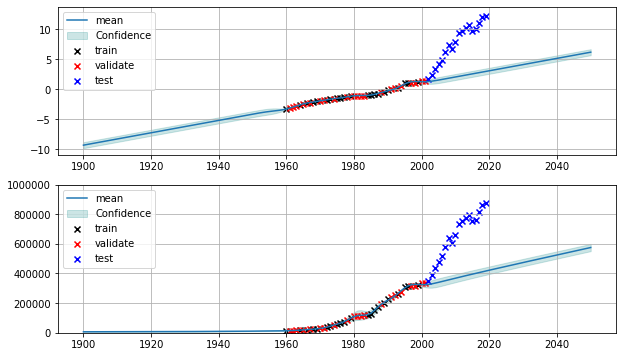

 20%|█▉        | 51/256 [01:10<05:18,  1.55s/it]

params:[ 1.09751037e-01 -2.17558859e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 8926.350992392621 
 test_rmse: 298828.9240713991



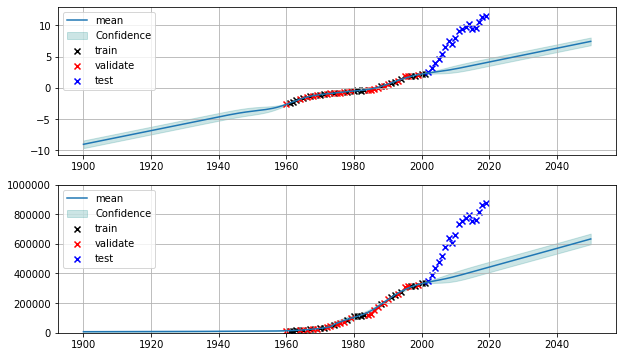

params:[ 1.08372611e-01 -2.14770898e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6375.53007827149 
 test_rmse: 301851.8364772721



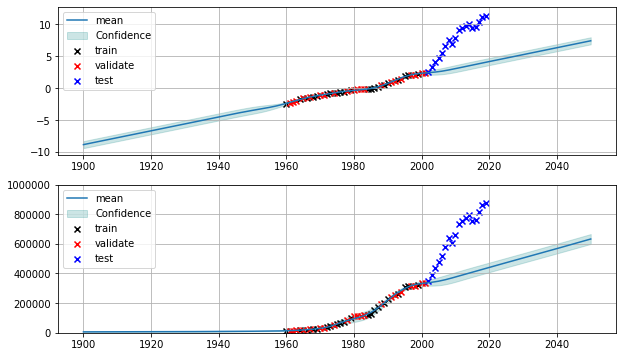

 20%|██        | 52/256 [01:11<05:06,  1.50s/it]

params:[ 1.04551625e-01 -2.08627875e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 8391.813591689392 
 test_rmse: 273144.81639711



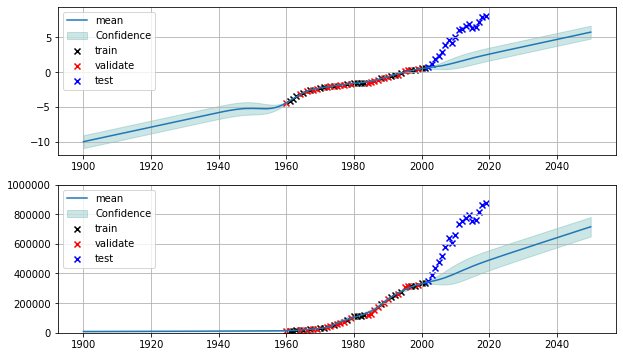

params:[ 1.04542227e-01 -2.08505391e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5249.458101733463 
 test_rmse: 259221.7567371193



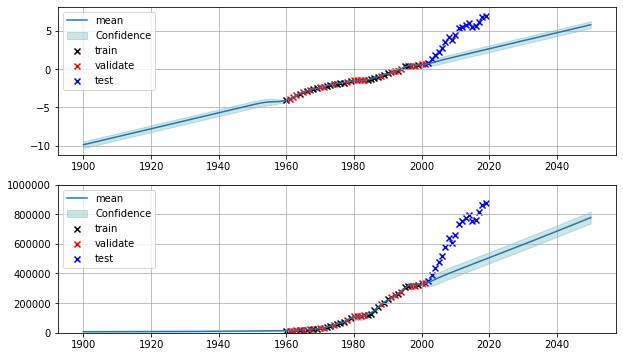

 21%|██        | 53/256 [01:13<04:53,  1.45s/it]

params:[ 1.10232247e-01 -2.18536549e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8733.058440131905 
 test_rmse: 297644.8013808242



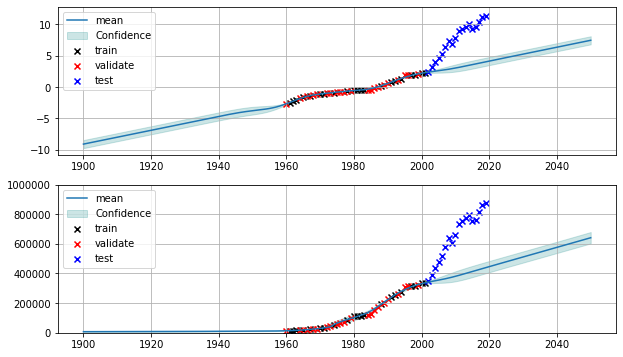

params:[ 1.09405941e-01 -2.16894818e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6784.958421871716 
 test_rmse: 294771.63382468495



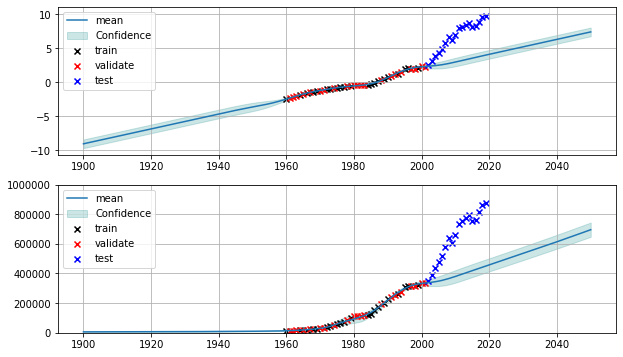

 21%|██        | 54/256 [01:14<04:58,  1.48s/it]

params:[ 1.08711981e-01 -2.16017506e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 8426.374237996171 
 test_rmse: 257992.04847764634



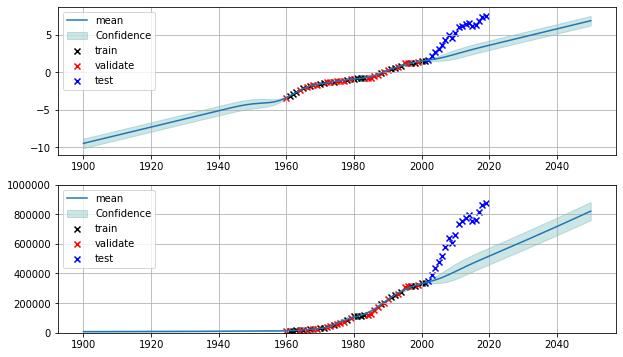

params:[ 1.09060583e-01 -2.16606265e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 4982.716373050751 
 test_rmse: 245577.96314620352



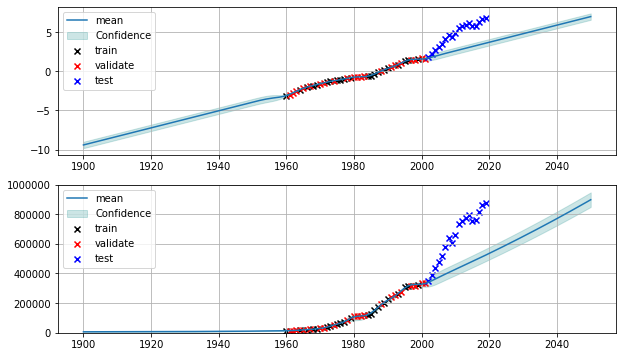

 21%|██▏       | 55/256 [01:16<04:52,  1.45s/it]

params:[ 1.12935919e-01 -2.23499419e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6391.45664053877 
 test_rmse: 229287.89098237344



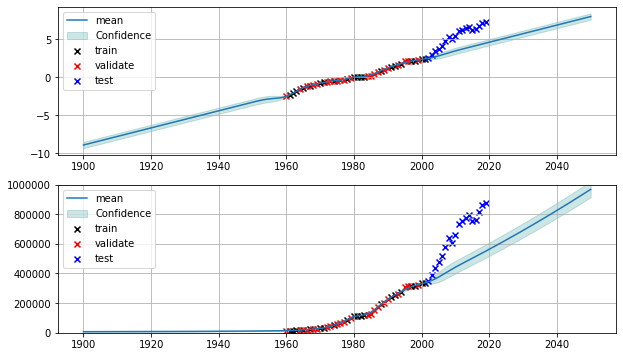

params:[ 1.17306675e-01 -2.32106380e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 4797.739036161055 
 test_rmse: 185992.6765781144



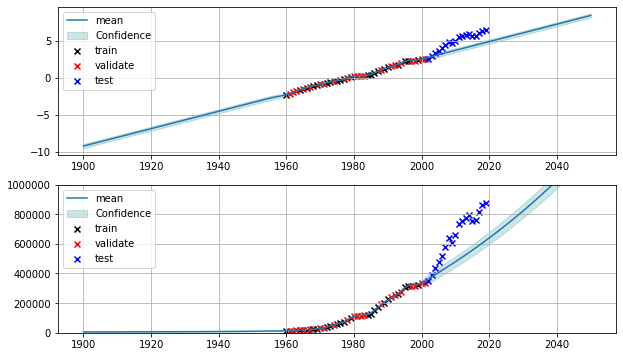

 22%|██▏       | 56/256 [01:17<05:07,  1.54s/it]

params:[ 1.16294281e-01 -2.32335924e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6265.969435560214 
 test_rmse: 222145.30065746055



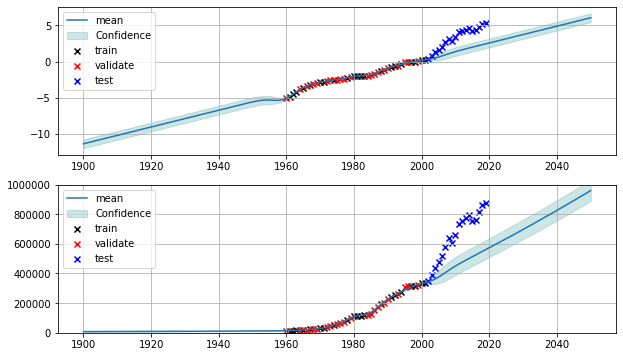

params:[ 1.11492623e-01 -2.22997090e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5460.138853806855 
 test_rmse: 135039.06282507195



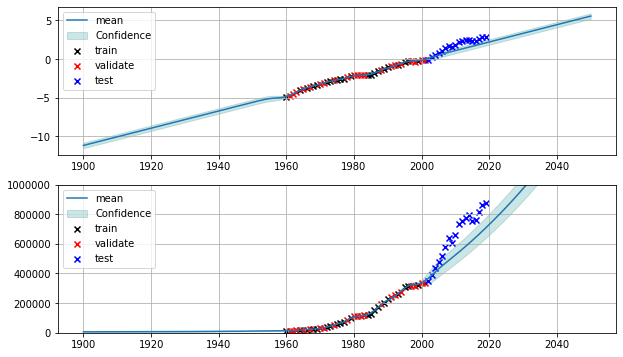

 22%|██▏       | 57/256 [01:19<04:54,  1.48s/it]

params:[ 1.09750964e-01 -2.17558715e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8926.357291591361 
 test_rmse: 298829.1536434181



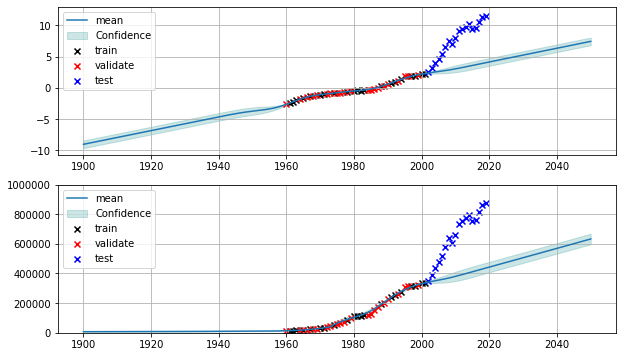

params:[ 1.08372661e-01 -2.14770999e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6375.529248765479 
 test_rmse: 301851.9993573691



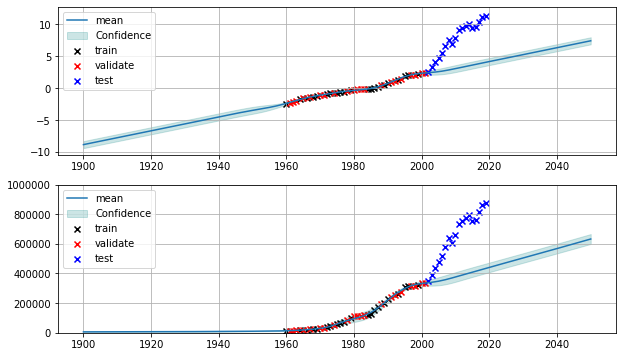

 23%|██▎       | 58/256 [01:20<04:49,  1.46s/it]

params:[ 1.08711935e-01 -2.16017413e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 8426.39324405032 
 test_rmse: 257992.42251287698



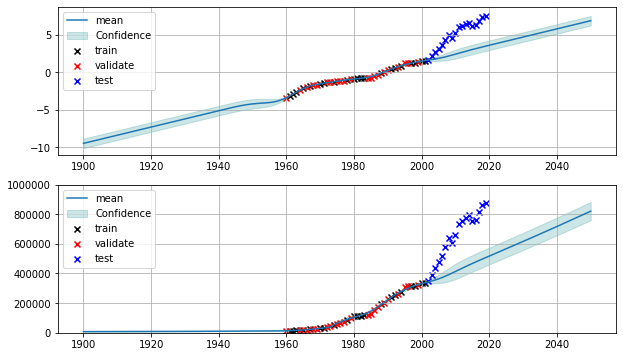

params:[ 1.09060535e-01 -2.16606167e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 4982.726525657617 
 test_rmse: 245578.4138278701



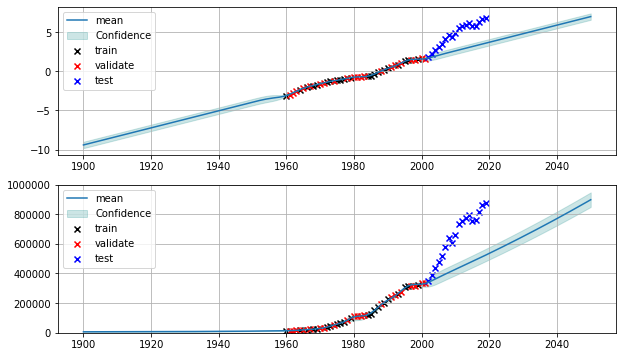

 23%|██▎       | 59/256 [01:22<05:18,  1.62s/it]

params:[ 1.12935957e-01 -2.23499493e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6391.457244563013 
 test_rmse: 229287.82622485704



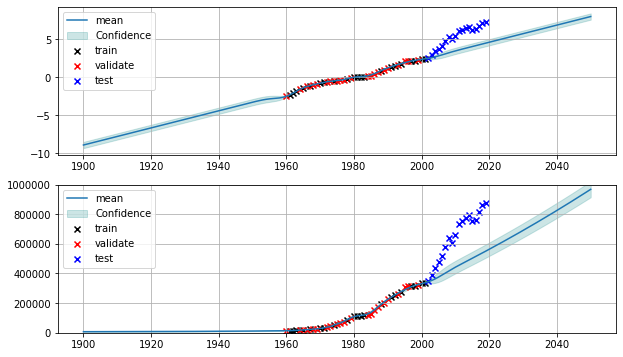

params:[ 1.17306487e-01 -2.32106010e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 4797.713116791446 
 test_rmse: 185993.83346542192



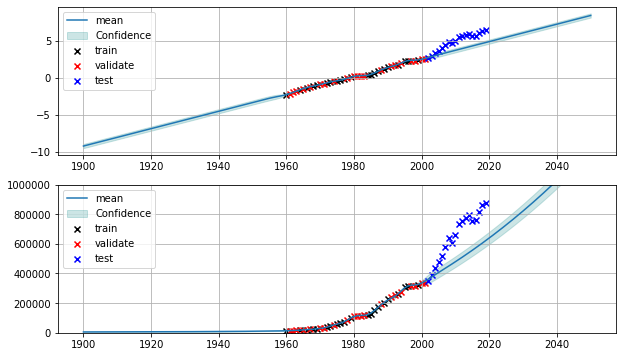

 23%|██▎       | 60/256 [01:24<05:06,  1.56s/it]

params:[ 1.16286820e-01 -2.31320777e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6265.523664945665 
 test_rmse: 222173.0780375937



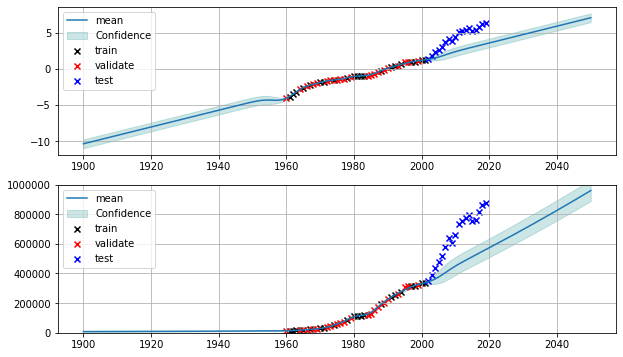

params:[ 1.10045129e-01 -2.19024012e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5429.90005928934 
 test_rmse: 135882.9803404271



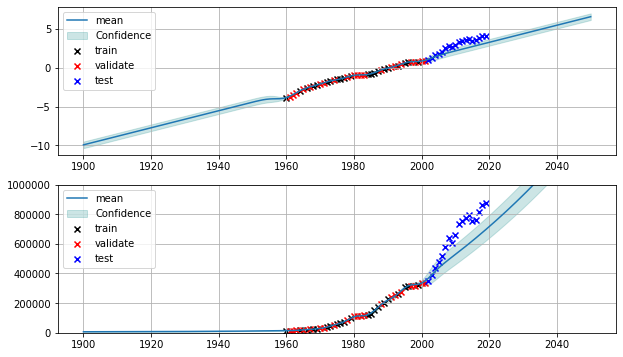

 24%|██▍       | 61/256 [01:25<04:56,  1.52s/it]

params:[ 1.12935978e-01 -2.23499534e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6391.459350770769 
 test_rmse: 229288.07967623172



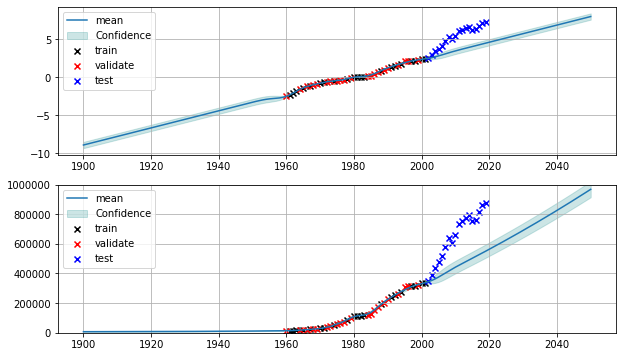

params:[ 1.17306501e-01 -2.32106036e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 4797.714851998527 
 test_rmse: 185993.75602177612



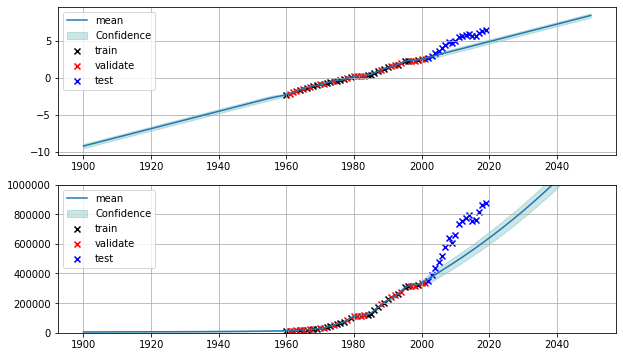

 24%|██▍       | 62/256 [01:27<05:40,  1.76s/it]

params:[ 1.18315793e-01 -2.34396009e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6103.280955293568 
 test_rmse: 208801.45960310765



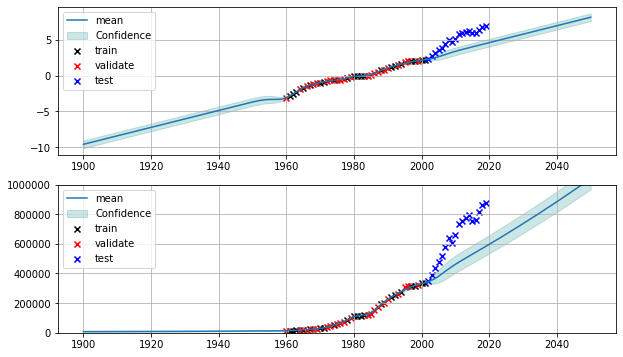

params:[ 1.14719820e-01 -2.27368975e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 7065.900177638413 
 test_rmse: 97681.15219272883



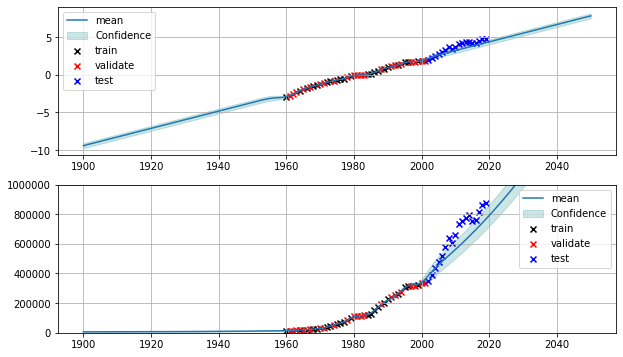

 25%|██▍       | 63/256 [01:29<05:26,  1.69s/it]

params:[ 1.21417068e-01 -2.39880488e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 5855.63055207292 
 test_rmse: 46229.15872550259



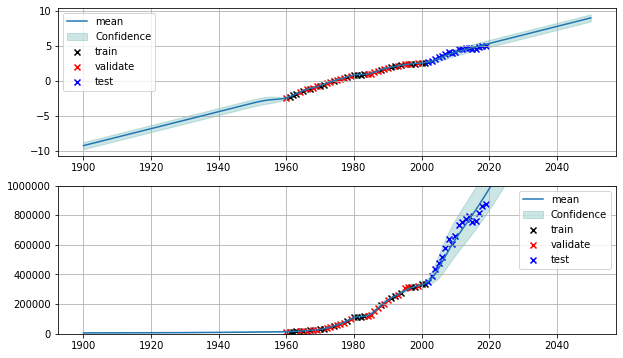

params:[ 1.19601024e-01 -2.36151348e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9285.893767979689 
 test_rmse: 53969.79095477022



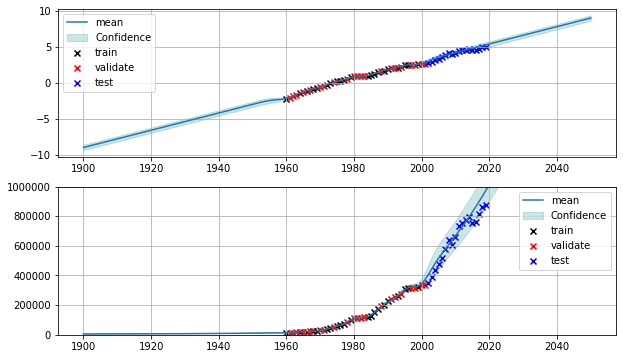

 25%|██▌       | 64/256 [01:30<05:14,  1.64s/it]

params:[ 6.16060350e-02 -1.27375818e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 10014.856039255612 
 test_rmse: 307416.85677134345



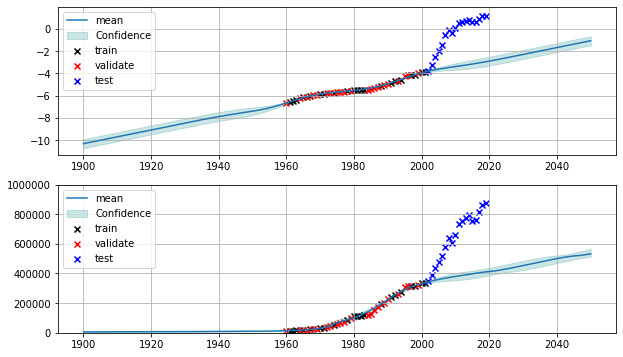

params:[ 5.57942028e-02 -1.15933767e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6383.8296157249315 
 test_rmse: 287556.19136772736



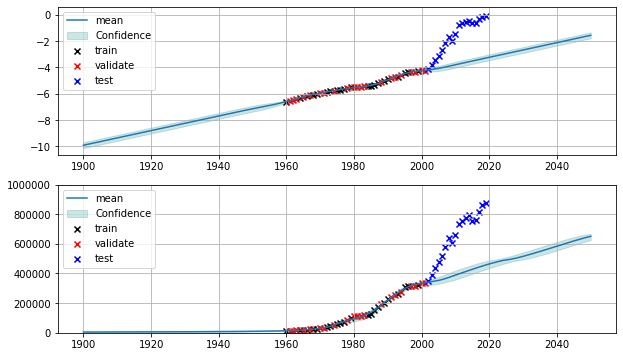

 25%|██▌       | 65/256 [01:32<04:52,  1.53s/it]

params:[ 9.51717306e-02 -1.88962087e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 9488.257237156944 
 test_rmse: 337305.49101487524



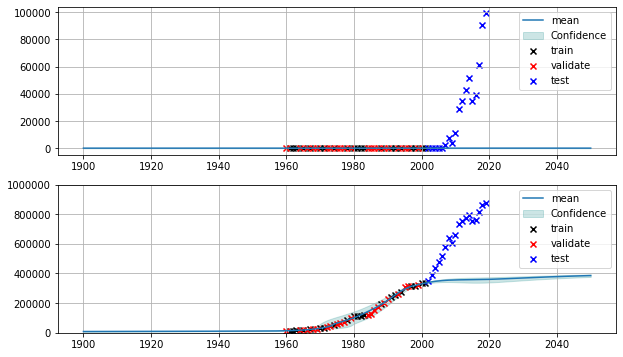

params:[ 9.87647875e-02 -1.95793742e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6449.3195949079645 
 test_rmse: 345548.00633865496



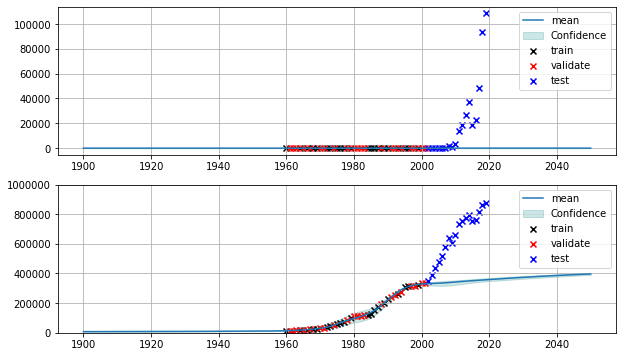

 26%|██▌       | 66/256 [01:33<04:53,  1.54s/it]

params:[ 8.99165517e-02 -1.79415561e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 9289.70158124645 
 test_rmse: 347748.32591730705



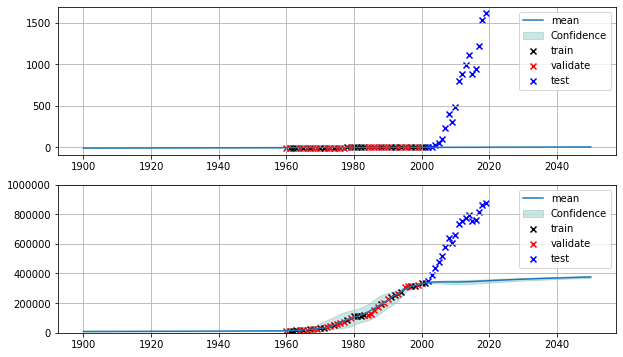

params:[ 9.61922525e-02 -1.91703130e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6053.091944957505 
 test_rmse: 349585.86957719043



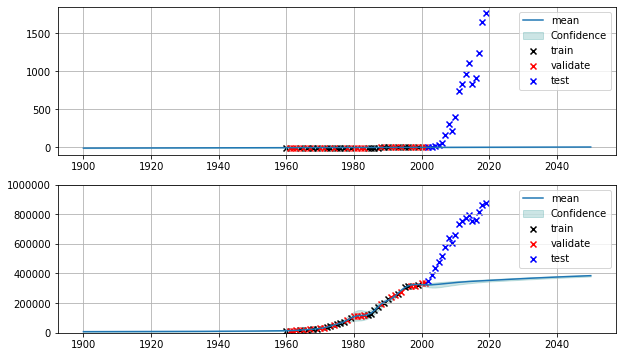

 26%|██▌       | 67/256 [01:35<04:46,  1.51s/it]

params:[ 9.58871211e-02 -1.90475480e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9289.75066046293 
 test_rmse: 337212.94774396345



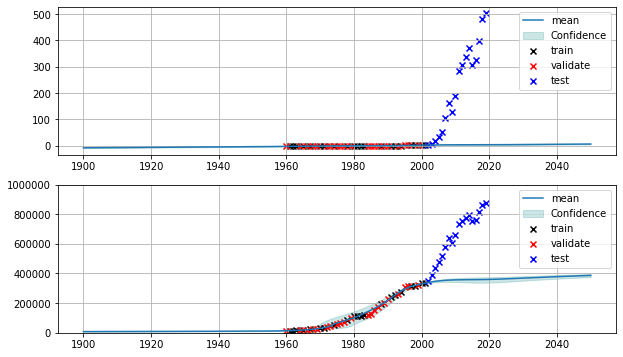

params:[ 9.94670015e-02 -1.97278015e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6483.096445812226 
 test_rmse: 347279.7724191029



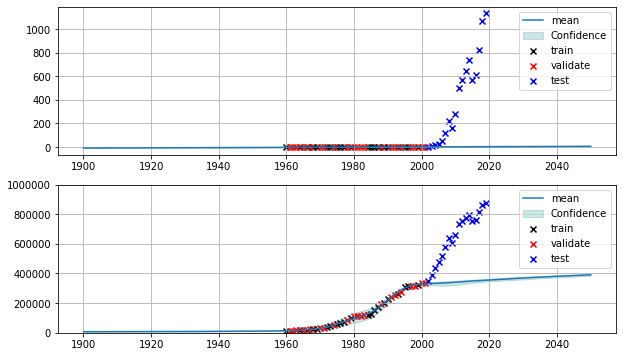

 27%|██▋       | 68/256 [01:36<04:38,  1.48s/it]

params:[ 9.28397407e-02 -1.85801949e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 8067.016914632031 
 test_rmse: 340717.4590887348



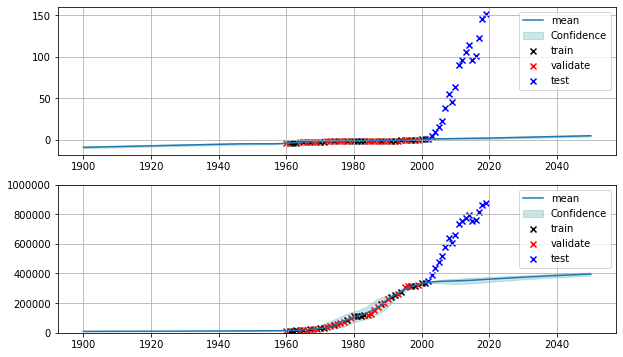

params:[ 9.51028435e-02 -1.90315701e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6176.519034545011 
 test_rmse: 343459.8157531375



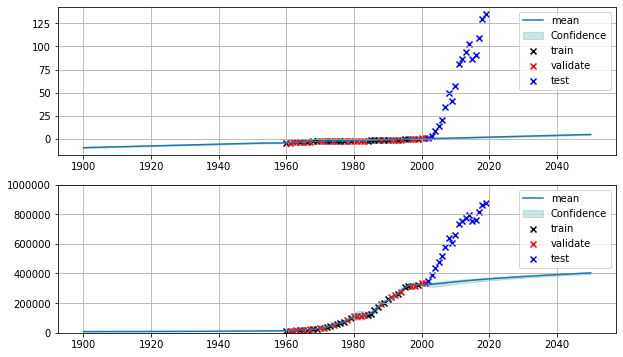

 27%|██▋       | 69/256 [01:37<04:29,  1.44s/it]

params:[ 8.99713004e-02 -1.78814812e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8524.408638290937 
 test_rmse: 345761.80121656257



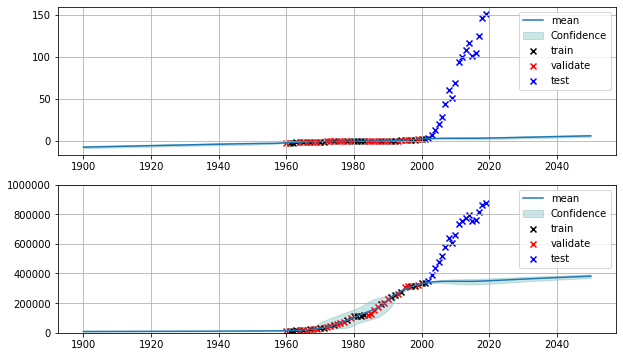

params:[ 9.35859540e-02 -1.86014855e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6879.307679132308 
 test_rmse: 357617.5663524241



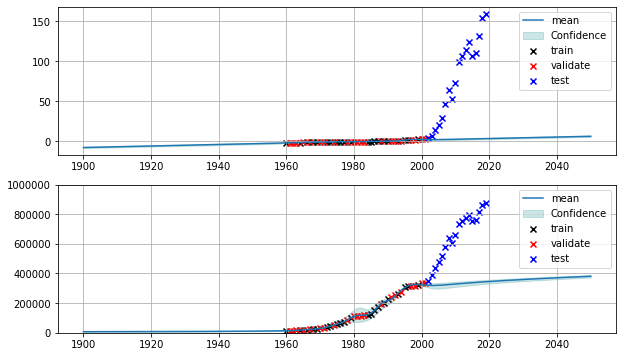

 27%|██▋       | 70/256 [01:39<04:23,  1.42s/it]

params:[ 9.40802737e-02 -1.87407511e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 8276.226147390926 
 test_rmse: 341272.4334732777



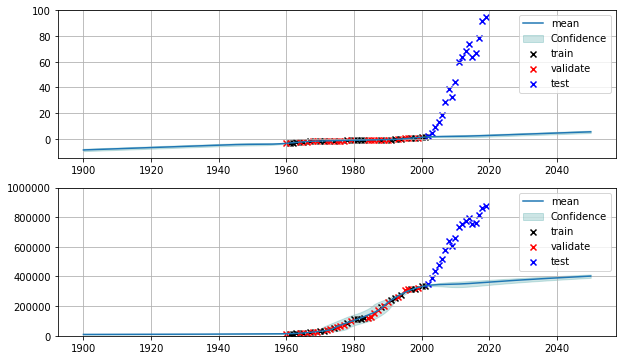

params:[ 9.58702026e-02 -1.91022083e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6275.572885958399 
 test_rmse: 345497.10020228586



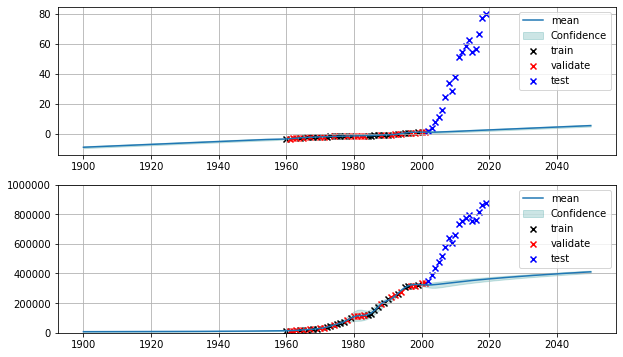

 28%|██▊       | 71/256 [01:40<04:17,  1.39s/it]

params:[ 1.02458978e-01 -2.03315993e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9300.958288162565 
 test_rmse: 331568.3719582611



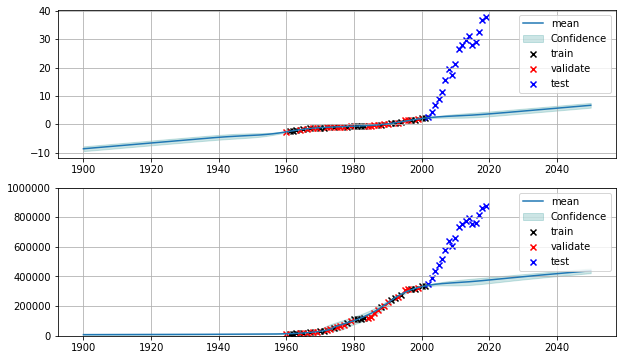

params:[ 1.02376217e-01 -2.03107913e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6340.107163166386 
 test_rmse: 339428.73444955965



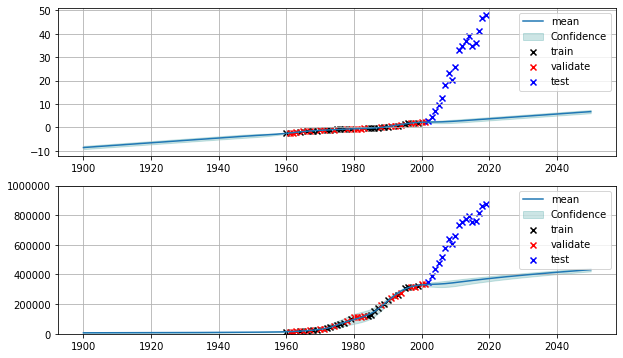

 28%|██▊       | 72/256 [01:42<04:20,  1.41s/it]

params:[ 9.74953787e-02 -1.95960243e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6781.96894037082 
 test_rmse: 327980.0825644824



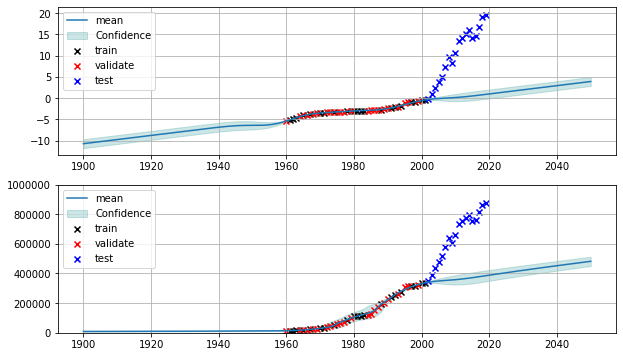

params:[ 1.01367411e-01 -2.03840231e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6730.565296691812 
 test_rmse: 316144.8376228411



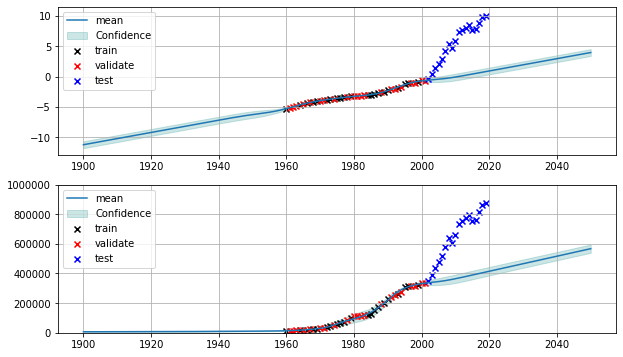

 29%|██▊       | 73/256 [01:43<04:14,  1.39s/it]

params:[ 8.94777117e-02 -1.77865469e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 7335.569839661427 
 test_rmse: 343366.96479951864



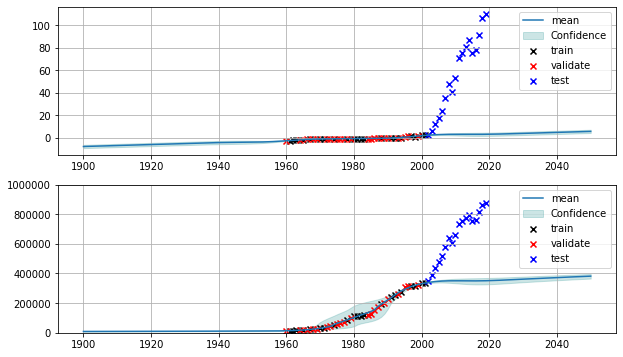

params:[ 9.58312583e-02 -1.90424467e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 7115.688949593433 
 test_rmse: 354709.89562554506



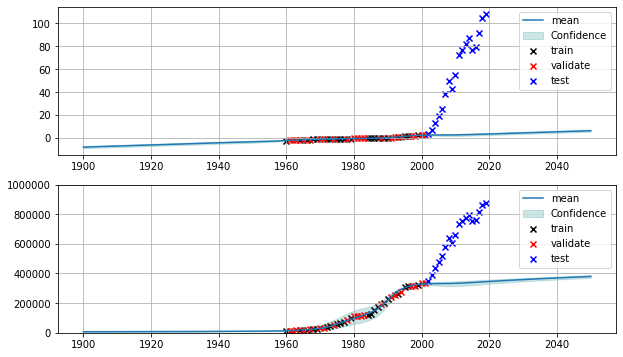

 29%|██▉       | 74/256 [01:44<04:09,  1.37s/it]

params:[ 8.99399839e-02 -1.79309484e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 7578.468699753814 
 test_rmse: 340723.188796476



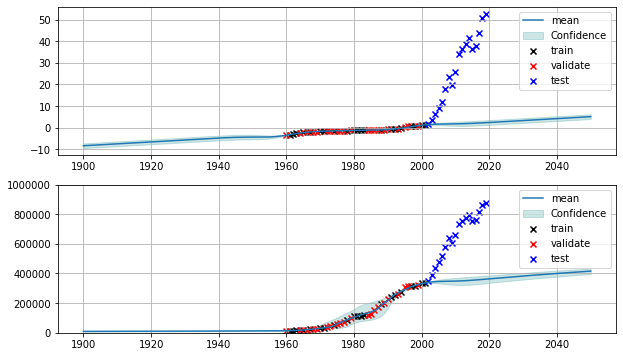

params:[ 9.71988703e-02 -1.93765783e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6873.763993869527 
 test_rmse: 346081.993112409



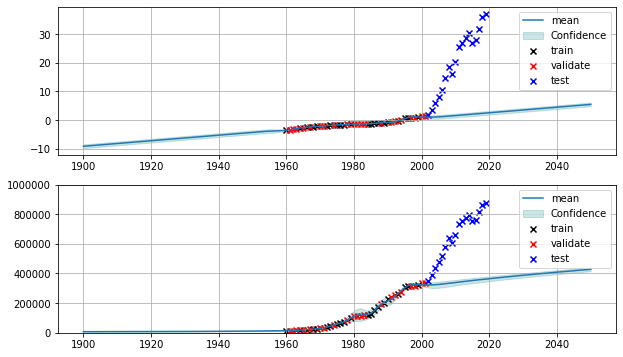

 29%|██▉       | 75/256 [01:46<04:05,  1.36s/it]

params:[ 9.63102719e-02 -1.91165936e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 7020.7850633980715 
 test_rmse: 335772.1655681131



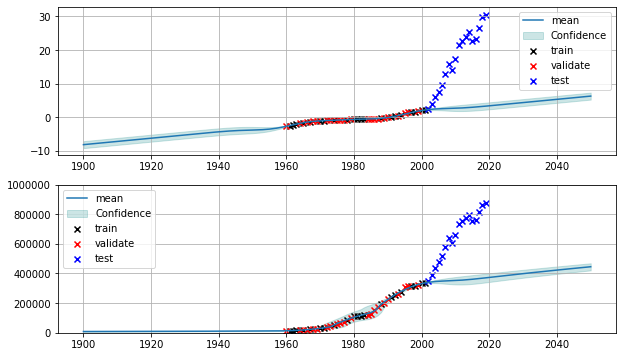

params:[ 1.04020272e-01 -2.06604095e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6121.445909813742 
 test_rmse: 339214.1069193984



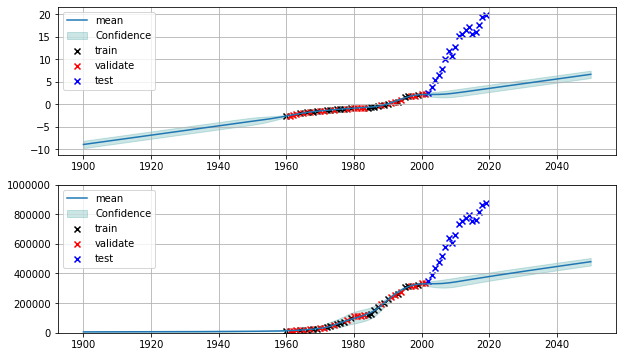

 30%|██▉       | 76/256 [01:47<04:04,  1.36s/it]

params:[ 9.87190157e-02 -1.97283314e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6962.258375421291 
 test_rmse: 325460.73122693493



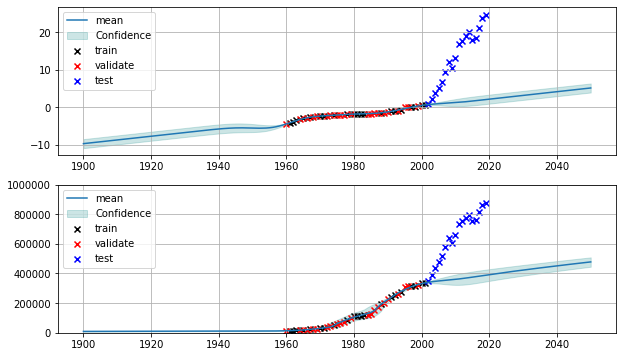

params:[ 1.04730597e-01 -2.09379280e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 6549.102731669715 
 test_rmse: 307225.28277639305



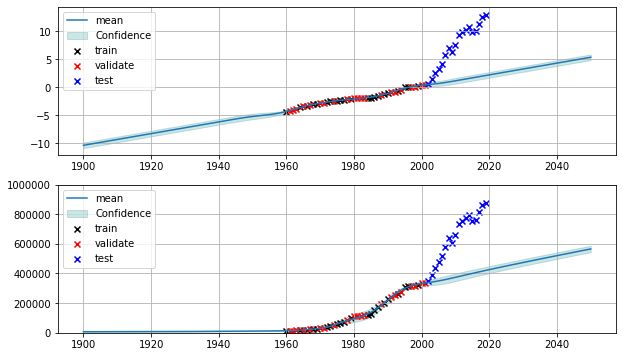

 30%|███       | 77/256 [01:48<04:00,  1.34s/it]

params:[ 9.63069275e-02 -1.91159301e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 7020.203554608807 
 test_rmse: 335775.51942050527



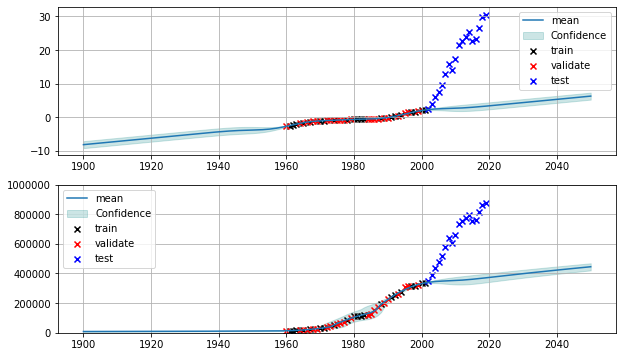

params:[ 1.04020864e-01 -2.06605278e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6121.465611281147 
 test_rmse: 339213.512536257



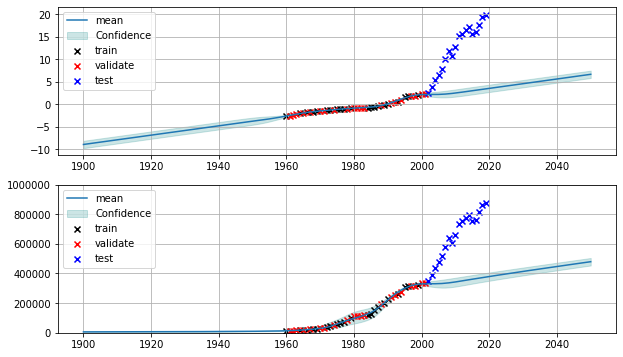

 30%|███       | 78/256 [01:50<04:00,  1.35s/it]

params:[ 1.00131005e-01 -1.99151968e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6991.371824269526 
 test_rmse: 324853.44242919295



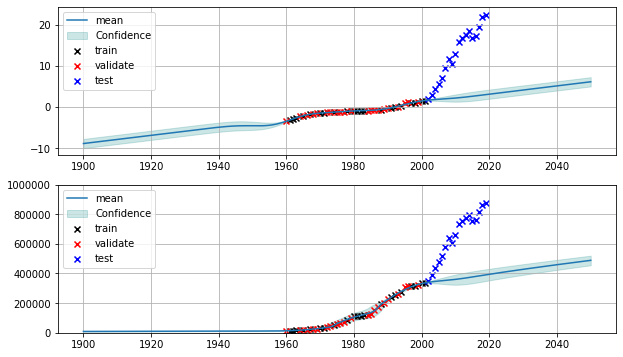

params:[ 1.05951903e-01 -2.10950957e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6242.220017758473 
 test_rmse: 308260.14835840906



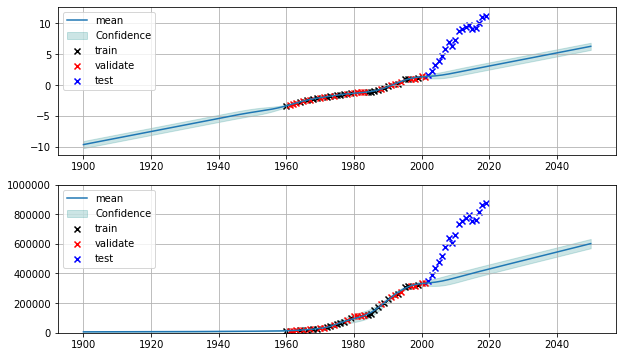

 31%|███       | 79/256 [01:51<03:56,  1.33s/it]

params:[ 1.09318383e-01 -2.16699026e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 9000.729719136974 
 test_rmse: 300384.74929107475



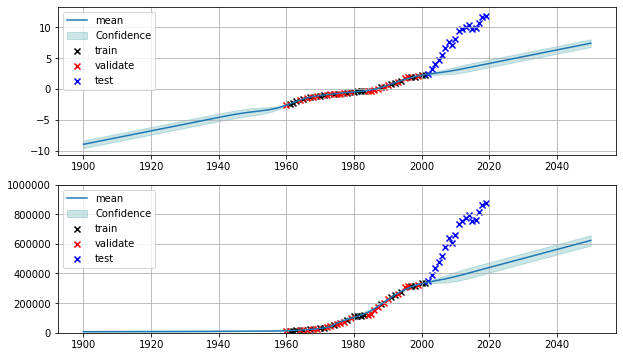

params:[ 1.07888176e-01 -2.13831681e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6425.796337038969 
 test_rmse: 304078.7085612802



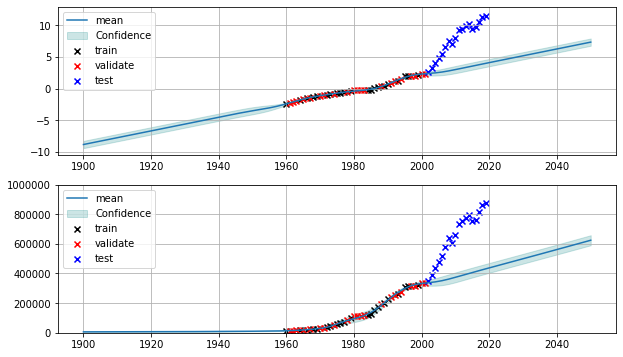

 31%|███▏      | 80/256 [01:52<03:55,  1.34s/it]

params:[ 9.20153757e-02 -1.86069139e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 8632.162109549314 
 test_rmse: 304376.6061224215



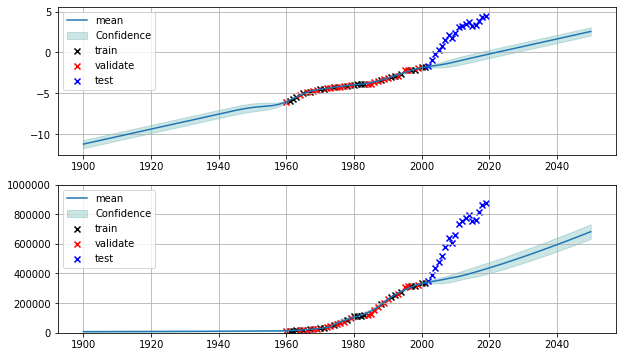

params:[ 9.36365840e-02 -1.89160256e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5340.844694958539 
 test_rmse: 295252.7959572346



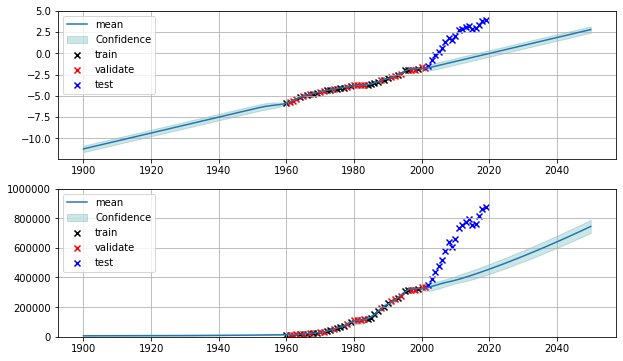

 32%|███▏      | 81/256 [01:54<03:53,  1.34s/it]

params:[ 9.55123351e-02 -1.89633962e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8343.282105320086 
 test_rmse: 340968.091226725



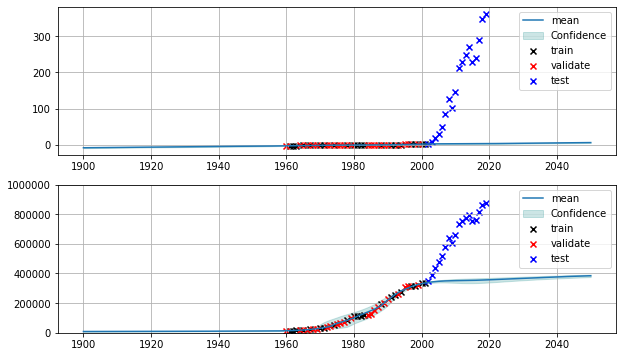

params:[ 9.53135827e-02 -1.89206549e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6461.227794018677 
 test_rmse: 353081.6041255716



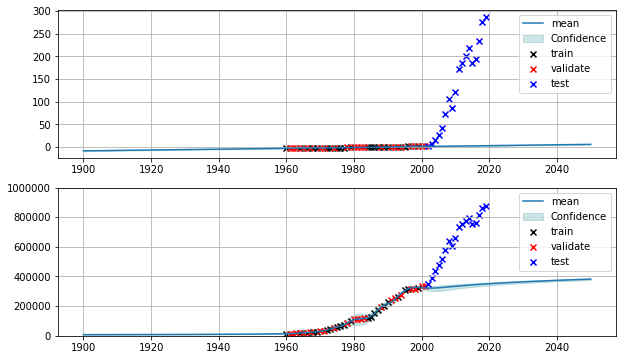

 32%|███▏      | 82/256 [01:55<03:50,  1.32s/it]

params:[ 9.24578144e-02 -1.84212492e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 8015.704426375322 
 test_rmse: 341605.7005055386



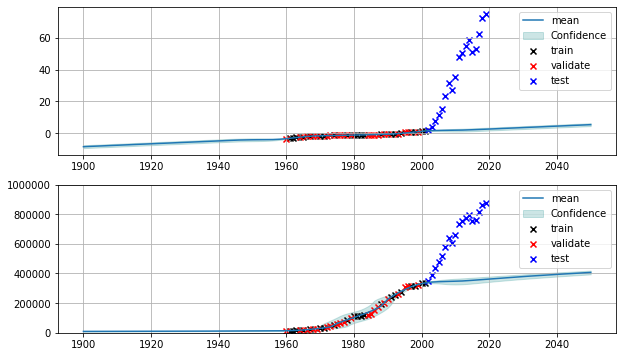

params:[ 9.66810683e-02 -1.92784276e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 6480.6688277929725 
 test_rmse: 344790.0501913776



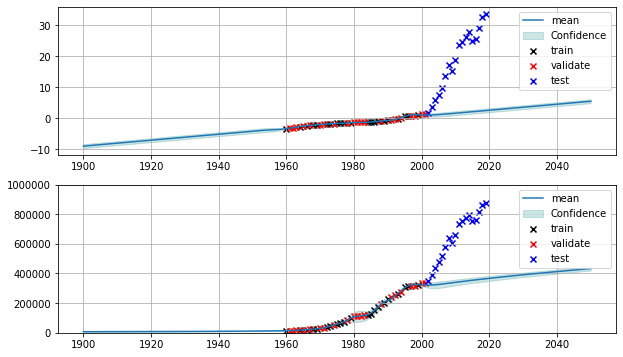

 32%|███▏      | 83/256 [01:56<03:45,  1.30s/it]

params:[ 1.00342400e-01 -1.99109243e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 8343.801372637628 
 test_rmse: 332172.239245717



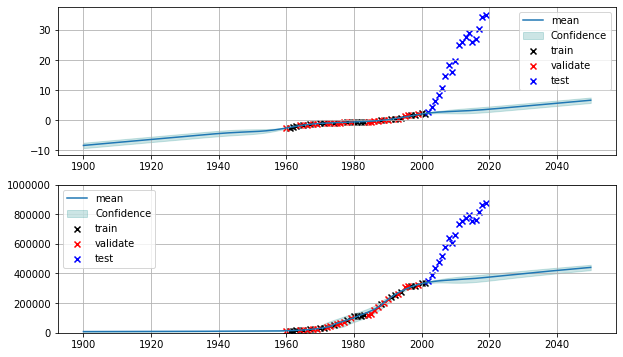

params:[ 1.00028266e-01 -1.98522305e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6380.322205807775 
 test_rmse: 342304.4882975554



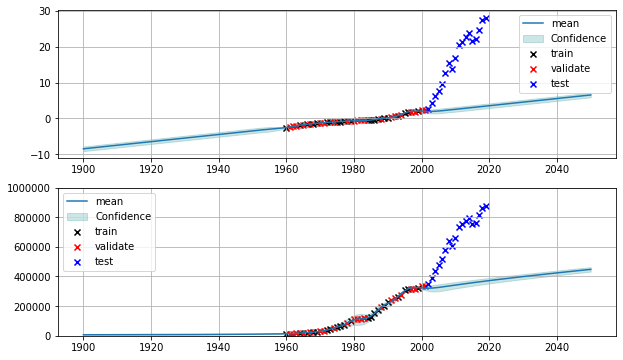

 33%|███▎      | 84/256 [01:57<03:43,  1.30s/it]

params:[ 1.01525505e-01 -2.02926449e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 7173.017553790511 
 test_rmse: 324140.85298289417



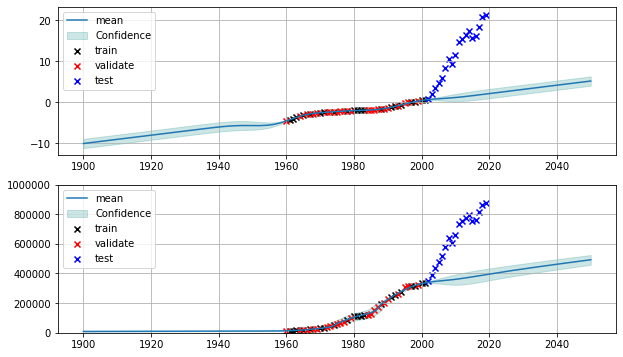

params:[ 9.99365633e-02 -1.99758842e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5741.361480358652 
 test_rmse: 314556.3736954635



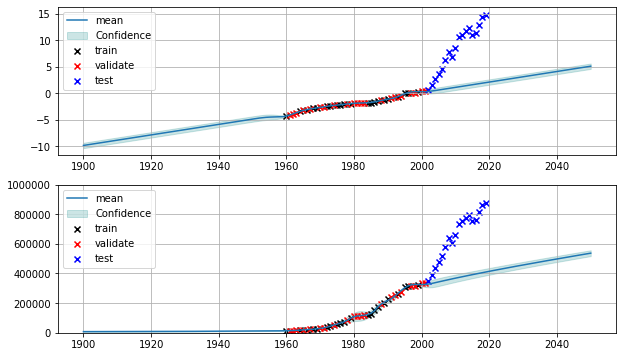

 33%|███▎      | 85/256 [01:59<03:51,  1.36s/it]

params:[ 9.68567867e-02 -1.92254798e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 7195.2888151985735 
 test_rmse: 335179.71145641204



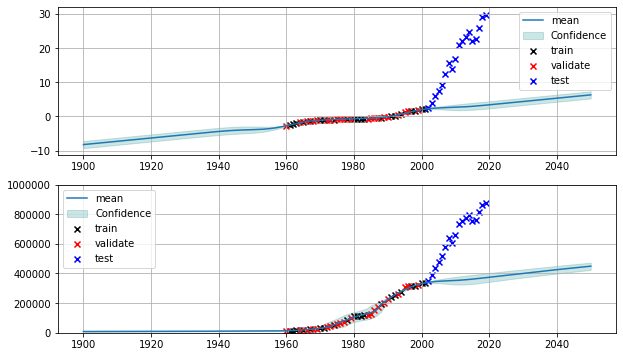

params:[ 1.00321318e-01 -1.99233121e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 6447.419015455221 
 test_rmse: 341672.5498004619



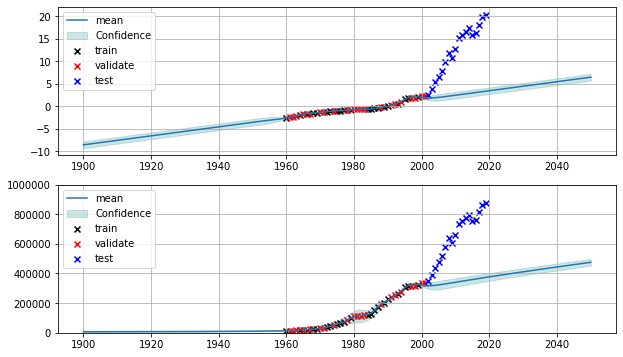

 34%|███▎      | 86/256 [02:00<03:50,  1.36s/it]

params:[ 1.01527625e-01 -2.01930906e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 7172.927566109795 
 test_rmse: 324138.3740561662



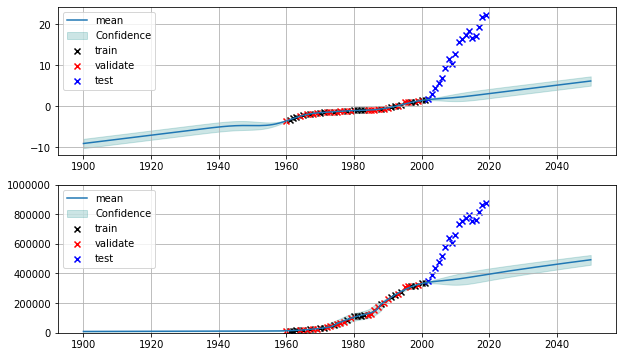

params:[ 1.01913748e-01 -2.02850963e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 5880.3719499729905 
 test_rmse: 315128.35523267486



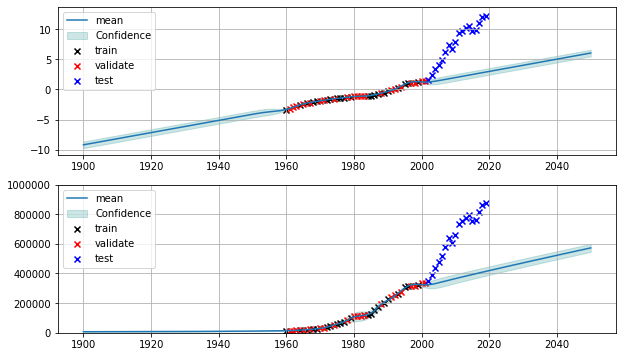

 34%|███▍      | 87/256 [02:02<03:55,  1.39s/it]

params:[ 1.10600935e-01 -2.19274062e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 8761.0741054537 
 test_rmse: 297505.6937311798



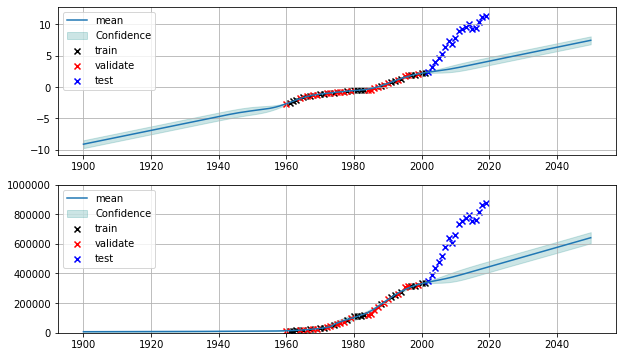

params:[ 1.09823148e-01 -2.17739745e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 6870.327771715232 
 test_rmse: 295483.35775321856



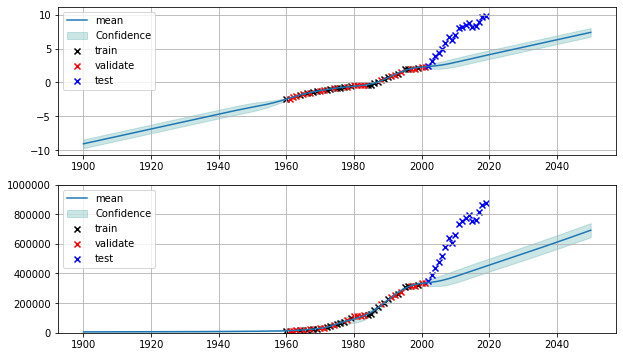

 34%|███▍      | 88/256 [02:03<03:46,  1.35s/it]

params:[ 1.04490628e-01 -2.09610266e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 8541.688484789 
 test_rmse: 273999.3946145784



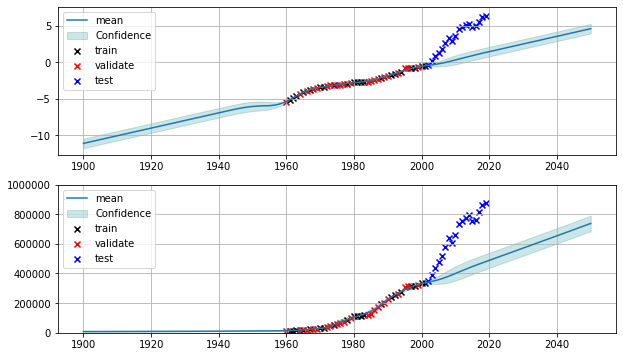

params:[ 1.04751763e-01 -2.10007429e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 5132.553396693561 
 test_rmse: 258887.56610889244



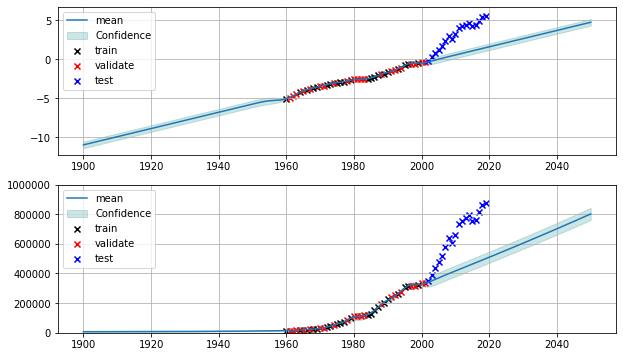

 35%|███▍      | 89/256 [02:05<03:54,  1.40s/it]

params:[ 1.00343063e-01 -1.99110565e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 8343.884884212373 
 test_rmse: 332172.1456785915



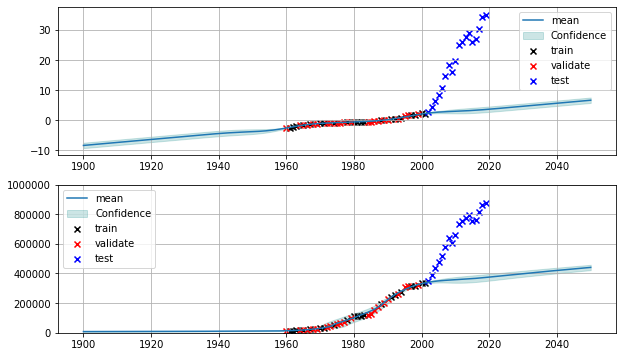

 35%|███▍      | 89/256 [02:05<03:56,  1.42s/it]


KeyboardInterrupt: 

In [20]:
result = grid_search(cwgp_regression, x_tv, y_tv, {"c":8,"n":[1],"transformations":["box_cox","sa"]},
                    cv=True, n_splits=2, shuffle=True,
                     x_test=x_test,y_test=y_test,ylim=[0,1000000],
                     mean_func=poly, init_params=(1,-0.1),
                     kernel = GPy.kern.RBF(1),
                    )